In [6]:
%cd /home/schilcherj/master/deepClustering/LMU_Master_Practical_SoSe24/

/home/schilcherj/master/deepClustering/LMU_Master_Practical_SoSe24


/home/schilcherj/master/deepClustering/deepClustEnv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import sys
import os

repo_path = os.path.sep.join(os.getcwd().split(os.path.sep)[:-3])
sys.path.append(repo_path)

# solves problems for Mac Users
os.chdir(repo_path)


In [7]:
%load_ext autoreload
%autoreload 2
from practical.DeepClustering.DipECT.dipect import Cluster_Tree, DipECT
from clustpy.deep._data_utils import get_dataloader
from clustpy.data.real_torchvision_data import load_mnist
from clustpy.deep.dipencoder import _Dip_Gradient, dip_test
from clustpy.deep.autoencoders import FeedforwardAutoencoder
import numpy as np
from sklearn.cluster import KMeans
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from clustpy.metrics import unsupervised_clustering_accuracy
import random
import umap
from sklearn.decomposition import PCA


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/schilcherj/master/deepClustering/deepClustEnv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_inital_projection_axis(X_embedd):
        """
        Returns the inital projection axis for the data in the given trainloader. Furthermore, the size of the higher projection cluster and the lower projection cluster will be returned (e.g to initialise pruning indicator).
        """
        # init projection axis on full dataset
        kmeans = KMeans(n_clusters=2, n_init=10).fit(X_embedd)
        kmeans_centers = kmeans.cluster_centers_
        labels = kmeans.labels_
        axis = kmeans_centers[0] - kmeans_centers[1]
        
        return axis, kmeans_centers[0], kmeans_centers[1]
def predict_subclusters(data, axis):
        projections = data @ axis
        sorted_indices = projections.argsort()
        dip_value, modal_interval, modal_triangle = dip_test(projections[sorted_indices], is_data_sorted=True, just_dip=False)
        index_lower, index_upper = modal_interval
        index_tri1, index_tri2, index_tri3 = modal_triangle
        if projections[sorted_indices[index_tri2]] > projections[sorted_indices[index_upper]]:
                treshhold =  (projections[sorted_indices[index_tri2]] + projections[sorted_indices[index_upper]])/2
        else:
                treshhold =  (projections[sorted_indices[index_tri2]] + projections[sorted_indices[index_lower]])/2
        labels = np.zeros(len(data))
        labels[projections >= treshhold] = 1
        labels[sorted_indices[index_tri2]] = 2
        labels[sorted_indices[index_lower]] = 3
        labels[sorted_indices[index_upper]] = 3
        return labels


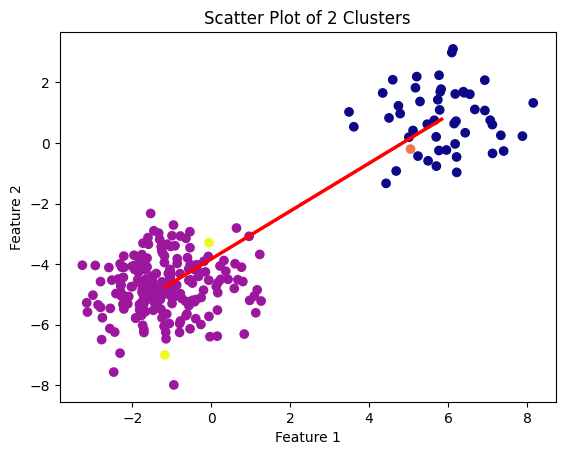

In [172]:


# Generate sample data
# X, y = make_blobs(n_samples=300, centers=2)
# Generate sample data with clusters of different sizes
X1, y1 = make_blobs(n_samples=50, centers=1,)
X2, y2 = make_blobs(n_samples=200, centers=1, )

# Combine the datasets
X = np.vstack((X1, X2))
y = np.hstack((y1, y2 + 1))  # Adjust labels for the second cluster

axis, c1, c2 = get_inital_projection_axis(X)

labels = predict_subclusters(X, axis)


# Create a scatter plot
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='plasma', marker='o')

# origin = [np.mean(X, axis=0)[0]], [np.mean(X, axis=0)[1]]  # Vector origin point
# plt.quiver(*origin, axis[0], axis[1], scale=5, color='red', label='Direction Vector')
plt.plot([c1[0], c2[0]], [c1[1], c2[1]], color='red',linewidth=2.5, label='Line between points')

# Add title and labels
plt.title('Scatter Plot of 2 Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Show plot
plt.show()

#assignments:  400
#assignments:  200
#assignments best node:  400
True
0.8166666666666667


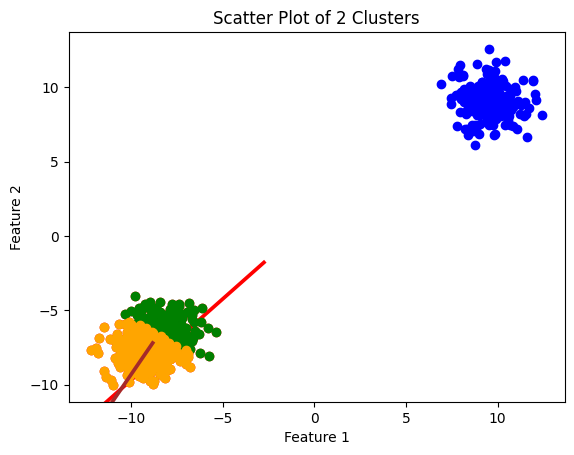

In [13]:
# Generate sample data
X, y = make_blobs(n_samples=600, centers=3)

# X1, y1 = make_blobs(n_samples=50, centers=1)
# X2, y2 = make_blobs(n_samples=200, centers=1)
# X3, y3 = make_blobs(n_samples=100, centers=1)
# X4, y4 = make_blobs(n_samples=250, centers=1)

# Combine the datasets
# X = np.vstack((X1, X2, X3, X4))
# y = np.hstack((y1, y2 + 1, y3 + 2, y4 + 3))  

dataloader = get_dataloader(X, 50 )
encode = lambda x: x
autoencoder = type("Autoencoder", (), {"encode": encode})

tree = Cluster_Tree(dataloader, autoencoder, None, "cpu", max_leaf_nodes=10)

tree.assign_to_tree(torch.from_numpy(X))

# Create a scatter plot
plt.scatter(tree.root.lower_projection_child.assignments[:, 0], tree.root.lower_projection_child.assignments[:, 1], c="blue", marker='o')
plt.scatter(tree.root.higher_projection_child.assignments[:, 0], tree.root.higher_projection_child.assignments[:, 1], c="red", marker='o')

origin = [np.mean(X, axis=0)[0]], [np.mean(X, axis=0)[1]]  # Vector origin point
plt.quiver(*origin, tree.root.projection_axis.data[0], tree.root.projection_axis.data[1], scale=5, color='red', label='Direction Vector')

# Add title and labels
plt.title('Scatter Plot of 2 Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Show plot


tree.grow_tree(dataloader, autoencoder, None, "max_leafs", 3.0, 1)
tree.assign_to_tree(torch.from_numpy(X))

pred_labels = np.ones(len(X))*-1

if tree.root.lower_projection_child.is_leaf_node():
    plt.scatter(tree.root.higher_projection_child.lower_projection_child.assignments[:, 0],tree.root.higher_projection_child.lower_projection_child.assignments[:, 1], c="green", marker='o')
    plt.scatter(tree.root.higher_projection_child.higher_projection_child.assignments[:, 0], tree.root.higher_projection_child.higher_projection_child.assignments[:, 1], c="orange", marker='o')

    origin = [np.mean(tree.root.higher_projection_child.assignments.numpy(), axis=0)[0]], [np.mean(tree.root.higher_projection_child.assignments.numpy(), axis=0)[1]]  # Vector origin point
    plt.quiver(*origin, tree.root.higher_projection_child.projection_axis.data[0], tree.root.higher_projection_child.projection_axis.data[1], scale=5, color='brown', label='Direction Vector')
    X_combined = torch.cat((tree.root.higher_projection_child.lower_projection_child.assignments, tree.root.higher_projection_child.higher_projection_child.assignments), dim=0)
    
    X_combined_sorted, _ = torch.sort(X_combined, dim=0)
    X_sorted, _ = torch.sort(tree.root.higher_projection_child.assignments, dim=0)

    # Check if the sorted tensors are identical
    is_identical = torch.equal(X_sorted, X_combined_sorted)
    print(is_identical)
    pred_labels[tree.root.higher_projection_child.lower_projection_child.assignment_indices] = 0
    pred_labels[tree.root.higher_projection_child.higher_projection_child.assignment_indices] = 1
    pred_labels[tree.root.lower_projection_child.assignment_indices] = 2
else:
    plt.scatter(tree.root.lower_projection_child.lower_projection_child.assignments[:, 0],tree.root.lower_projection_child.lower_projection_child.assignments[:, 1], c="green", marker='o')
    plt.scatter(tree.root.lower_projection_child.higher_projection_child.assignments[:, 0], tree.root.lower_projection_child.higher_projection_child.assignments[:, 1], c="orange", marker='o')
    origin = [np.mean(tree.root.lower_projection_child.assignments.numpy(), axis=0)[0]], [np.mean(tree.root.lower_projection_child.assignments.numpy(), axis=0)[1]]  # Vector origin point
    plt.quiver(*origin, tree.root.lower_projection_child.projection_axis.data[0], tree.root.lower_projection_child.projection_axis.data[1], scale=5, color='brown', label='Direction Vector')

    X_combined = torch.cat((tree.root.lower_projection_child.lower_projection_child.assignments, tree.root.lower_projection_child.higher_projection_child.assignments), dim=0)

    X_combined_sorted, _ = torch.sort(X_combined, dim=0)
    X_sorted, _ = torch.sort(tree.root.lower_projection_child.assignments, dim=0)

    # Check if the sorted tensors are identical
    is_identical = torch.equal(X_sorted, X_combined_sorted)
    print(is_identical)
    pred_labels[tree.root.lower_projection_child.lower_projection_child.assignment_indices] = 0
    pred_labels[tree.root.lower_projection_child.higher_projection_child.assignment_indices] = 1
    pred_labels[tree.root.higher_projection_child.assignment_indices] = 2

print(unsupervised_clustering_accuracy(y, pred_labels))
plt.show()


In [28]:
data = load_mnist()["data"]
encode = lambda x: x
autoencoder = type("Autoencoder", (), {"encode": encode})

tree = Cluster_Tree(dataloader, autoencoder, None, "cpu", max_leaf_nodes=20)

In [25]:
dataset, labels = load_mnist(return_X_y=True)
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/pretrained_AE_test.pth"))
autoencoder.fitted = True

dipect_p1 = DipECT(autoencoder=autoencoder, consider_num_assignments_for_growing=True, unimodal_treshhold=0.95)
dipect_p1 = dipect_p1.fit_predict(dataset)

cpu


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  40374
#assignments:  29626


Epoch 2/40:   0%|          | 1/274 [00:05<23:57,  5.27s/batch]

#assignments best node:  40374


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  19428
#assignments:  21389
#assignments:  29183


Epoch 4/40:   0%|          | 0/274 [00:08<?, ?batch/s]

#assignments best node:  19428


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  14208
#assignments:  5044
#assignments:  21556
#assignments:  29192


Epoch 6/40:   0%|          | 0/274 [00:09<?, ?batch/s]

#assignments best node:  14208


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  7236
#assignments:  6871
#assignments:  5128
#assignments:  21594
#assignments:  29171


Epoch 8/40:   0%|          | 0/274 [00:08<?, ?batch/s]

#assignments best node:  21594


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  7150
#assignments:  6834
#assignments:  5217
#assignments:  8312
#assignments:  13464
#assignments:  29023


Epoch 10/40:   0%|          | 0/274 [00:10<?, ?batch/s]

#assignments best node:  13464


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  7099
#assignments:  6762
#assignments:  5133
#assignments:  8492
#assignments:  7054
#assignments:  6398
#assignments:  29062


Epoch 12/40:   0%|          | 0/274 [00:11<?, ?batch/s]

#assignments best node:  8492


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  7091
#assignments:  6745
#assignments:  5206
#assignments:  6656
#assignments:  1842
#assignments:  7013
#assignments:  6344
#assignments:  29103


Epoch 14/40:   0%|          | 0/274 [00:09<?, ?batch/s]

#assignments best node:  29103


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  7096
#assignments:  6772
#assignments:  5142
#assignments:  6585
#assignments:  1911
#assignments:  7043
#assignments:  6362
#assignments:  20966
#assignments:  8123


Epoch 16/40:   0%|          | 0/274 [00:12<?, ?batch/s]

#assignments best node:  20966


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  7071
#assignments:  6688
#assignments:  5171
#assignments:  6668
#assignments:  1883
#assignments:  7039
#assignments:  6413
#assignments:  7218
#assignments:  13723
#assignments:  8126


Epoch 18/40:   0%|          | 0/274 [00:13<?, ?batch/s]

#assignments best node:  13723


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  7062
#assignments:  6689
#assignments:  5135
#assignments:  6678
#assignments:  1926
#assignments:  7037
#assignments:  6407
#assignments:  7358
#assignments:  6869
#assignments:  6703
#assignments:  8136


Epoch 20/40:   0%|          | 0/274 [00:14<?, ?batch/s]

#assignments best node:  8136


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  7065
#assignments:  6710
#assignments:  5234
#assignments:  6626
#assignments:  1871
#assignments:  7026
#assignments:  6343
#assignments:  7500
#assignments:  6851
#assignments:  6632
#assignments:  3907
#assignments:  4235


Epoch 22/40:   0%|          | 0/274 [00:14<?, ?batch/s]

#assignments best node:  5234


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  7031
#assignments:  6745
#assignments:  2310
#assignments:  2925
#assignments:  6708
#assignments:  1860
#assignments:  7030
#assignments:  6352
#assignments:  7433
#assignments:  6851
#assignments:  6597
#assignments:  3826
#assignments:  4332


Epoch 24/40:   0%|          | 0/274 [00:13<?, ?batch/s]

#assignments best node:  2925


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  7048
#assignments:  6689
#assignments:  2145
#assignments:  1086
#assignments:  1988
#assignments:  6694
#assignments:  1898
#assignments:  7095
#assignments:  6370
#assignments:  7375
#assignments:  6820
#assignments:  6644
#assignments:  3891
#assignments:  4257


Epoch 26/40:   0%|          | 0/274 [00:17<?, ?batch/s]

#assignments best node:  1086


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  7008
#assignments:  6710
#assignments:  2132
#assignments:  731
#assignments:  915
#assignments:  1444
#assignments:  6721
#assignments:  1902
#assignments:  7032
#assignments:  6391
#assignments:  7395
#assignments:  6836
#assignments:  6605
#assignments:  3913
#assignments:  4265


Epoch 28/40:   0%|          | 0/274 [00:27<?, ?batch/s]

#assignments best node:  731


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  7032
#assignments:  6707
#assignments:  2586
#assignments:  325
#assignments:  277
#assignments:  708
#assignments:  1354
#assignments:  6762
#assignments:  1905
#assignments:  7017
#assignments:  6345
#assignments:  7457
#assignments:  6786
#assignments:  6598
#assignments:  3804
#assignments:  4337


Epoch 30/40:   0%|          | 0/274 [00:16<?, ?batch/s]

#assignments best node:  277


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  7026
#assignments:  6701
#assignments:  2606
#assignments:  293
#assignments:  117
#assignments:  115
#assignments:  632
#assignments:  1439
#assignments:  6761
#assignments:  1920
#assignments:  7019
#assignments:  6374
#assignments:  7431
#assignments:  6782
#assignments:  6650
#assignments:  3792
#assignments:  4342


Epoch 32/40:   0%|          | 0/274 [00:20<?, ?batch/s]

#assignments best node:  115


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  6994
#assignments:  6689
#assignments:  2610
#assignments:  509
#assignments:  141
#assignments:  27
#assignments:  96
#assignments:  758
#assignments:  1076
#assignments:  6773
#assignments:  1961
#assignments:  7021
#assignments:  6378
#assignments:  7431
#assignments:  6788
#assignments:  6623
#assignments:  3934
#assignments:  4191


Epoch 34/40:   0%|          | 0/274 [00:20<?, ?batch/s]

#assignments best node:  27


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  6989
#assignments:  6690
#assignments:  2590
#assignments:  676
#assignments:  156
#assignments:  53
#assignments:  37
#assignments:  57
#assignments:  682
#assignments:  937
#assignments:  6733
#assignments:  1921
#assignments:  7005
#assignments:  6407
#assignments:  7455
#assignments:  6809
#assignments:  6658
#assignments:  3873
#assignments:  4272


Epoch 36/40:   0%|          | 0/274 [00:21<?, ?batch/s]

#assignments best node:  4272


Predict: 100%|██████████| 274/274 [00:06<00:00, 42.31it/s]


In [27]:
print(dipect_p1.tree_.flat_accuracy(labels, 10))
print(dipect_p1.tree_.flat_nmi(labels, 10))

0.8376857142857143
0.8545142496503885


In [11]:
dataset, labels = load_mnist(return_X_y=True)
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/pretrained_AE.pth"))
autoencoder.fitted = True

dipect_p2 = DipECT(autoencoder=autoencoder, consider_num_assignments_for_growing=True, unimodal_treshhold=0.975)
dipect_p2 = dipect_p2.fit_predict(dataset)

cpu


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  40758
#assignments:  29242


Epoch 2/40:   0%|          | 1/274 [00:06<31:44,  6.98s/batch]

#assignments best node:  40758


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  19217
#assignments:  21722
#assignments:  29061


Epoch 4/40:   0%|          | 1/274 [00:08<37:09,  8.17s/batch]

#assignments best node:  19217


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  14152
#assignments:  5024
#assignments:  21690
#assignments:  29134


Epoch 6/40:   0%|          | 0/274 [00:08<?, ?batch/s]

#assignments best node:  14152


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  6753
#assignments:  7216
#assignments:  4982
#assignments:  21856


Epoch 8/40:   0%|          | 0/274 [00:05<?, ?batch/s]

#assignments:  29193
#assignments best node:  21856


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  6774
#assignments:  7136
#assignments:  5045
#assignments:  8398
#assignments:  13562
#assignments:  29085


Epoch 10/40:   0%|          | 0/274 [00:08<?, ?batch/s]

#assignments best node:  8398


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  6751
#assignments:  7103
#assignments:  5064
#assignments:  1980
#assignments:  6522
#assignments:  13462
#assignments:  29118


Epoch 12/40:   0%|          | 0/274 [00:10<?, ?batch/s]

#assignments best node:  13462


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  6787
#assignments:  7041
#assignments:  5148
#assignments:  1941
#assignments:  6718
#assignments:  6970
#assignments:  6365
#assignments:  29030


Epoch 14/40:   0%|          | 1/274 [00:09<44:52,  9.86s/batch]

#assignments best node:  29030


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  6759
#assignments:  7064
#assignments:  5104
#assignments:  1957
#assignments:  6674
#assignments:  6937
#assignments:  6391
#assignments:  8192
#assignments:  20922


Epoch 16/40:   0%|          | 0/274 [00:13<?, ?batch/s]

#assignments best node:  20922


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  6733
#assignments:  7069
#assignments:  5107
#assignments:  1967
#assignments:  6638
#assignments:  6936
#assignments:  6414
#assignments:  8200
#assignments:  13380
#assignments:  7556


Epoch 18/40:   0%|          | 0/274 [00:11<?, ?batch/s]

#assignments best node:  13380


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  6751
#assignments:  7038
#assignments:  5112
#assignments:  1994
#assignments:  6688
#assignments:  6962
#assignments:  6406
#assignments:  8107
#assignments:  6631
#assignments:  6856
#assignments:  7455


Epoch 20/40:   0%|          | 0/274 [00:12<?, ?batch/s]

#assignments best node:  8107


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  6753
#assignments:  7040
#assignments:  5110
#assignments:  1967
#assignments:  6641
#assignments:  6936
#assignments:  6388
#assignments:  3938
#assignments:  4228
#assignments:  6696
#assignments:  6828
#assignments:  7475


Epoch 22/40:   0%|          | 0/274 [00:14<?, ?batch/s]

#assignments best node:  6388


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  6760
#assignments:  7029
#assignments:  5033
#assignments:  2037
#assignments:  6681
#assignments:  6986
#assignments:  3385
#assignments:  3025
#assignments:  3871
#assignments:  4312
#assignments:  6632
#assignments:  6805
#assignments:  7444


Epoch 24/40:   0%|          | 0/274 [00:10<?, ?batch/s]

#assignments best node:  5033


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  6714
#assignments:  7018
#assignments:  2640
#assignments:  2334
#assignments:  2102
#assignments:  6757
#assignments:  6995
#assignments:  3451
#assignments:  2915
#assignments:  3855
#assignments:  4306
#assignments:  6566
#assignments:  6811
#assignments:  7536


Epoch 26/40:   0%|          | 0/274 [00:15<?, ?batch/s]

#assignments best node:  2915


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  6731
#assignments:  6994
#assignments:  2230
#assignments:  2830
#assignments:  2045
#assignments:  6726
#assignments:  6990
#assignments:  3393
#assignments:  1830
#assignments:  1145
#assignments:  3912
#assignments:  4265
#assignments:  6600
#assignments:  6835
#assignments:  7474


Epoch 28/40:   0%|          | 0/274 [00:18<?, ?batch/s]

#assignments best node:  6600


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  6753
#assignments:  7035
#assignments:  3133
#assignments:  1963
#assignments:  2032
#assignments:  6750
#assignments:  6942
#assignments:  3465
#assignments:  1553
#assignments:  1353
#assignments:  3948
#assignments:  4211
#assignments:  2639
#assignments:  3982
#assignments:  6796
#assignments:  7445


Epoch 30/40:   0%|          | 0/274 [00:12<?, ?batch/s]

#assignments best node:  3133


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  6727
#assignments:  7008
#assignments:  1582
#assignments:  1353
#assignments:  2148
#assignments:  2047
#assignments:  6788
#assignments:  6923
#assignments:  3369
#assignments:  1595
#assignments:  1427
#assignments:  3909
#assignments:  4219
#assignments:  2869
#assignments:  3674
#assignments:  6823
#assignments:  7539


Epoch 32/40:   0%|          | 0/274 [00:19<?, ?batch/s]

#assignments best node:  4219


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  6775
#assignments:  7036
#assignments:  1522
#assignments:  1231
#assignments:  2391
#assignments:  2012
#assignments:  6754
#assignments:  6882
#assignments:  3263
#assignments:  1634
#assignments:  1488
#assignments:  4009
#assignments:  2097
#assignments:  2035
#assignments:  3012
#assignments:  3516
#assignments:  6803
#assignments:  7540


Epoch 34/40:   0%|          | 0/274 [00:17<?, ?batch/s]

#assignments best node:  1488


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  6714
#assignments:  7038
#assignments:  822
#assignments:  1773
#assignments:  2550
#assignments:  2043
#assignments:  6765
#assignments:  6893
#assignments:  3361
#assignments:  1060
#assignments:  1413
#assignments:  561
#assignments:  3976
#assignments:  2101
#assignments:  2047
#assignments:  3137
#assignments:  3439
#assignments:  6790
#assignments:  7517


Epoch 36/40:   0%|          | 0/274 [00:19<?, ?batch/s]

#assignments best node:  6790


Predict: 100%|██████████| 274/274 [00:03<00:00, 80.12it/s]


In [12]:
print(dipect_p2.tree_.flat_accuracy(labels, 10))
print(dipect_p2.tree_.flat_nmi(labels, 10))

0.8364857142857143
0.8534195945889934


In [42]:
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/pretrained_AE.pth"))
autoencoder.fitted = True

dipect_view_iterations = DipECT(autoencoder=autoencoder, grow_interval=300, max_iterations=5000) # wenn batch_size=len(dataset), cluster loss fällt monoton
dipect_view_iterations = dipect_view_iterations.fit_predict(dataset)

cpu


Fit:   0%|          | 3/5000 [00:00<09:29,  8.77it/s]

1.928193747997284
-0.032504480332136154
1.4340780377388
-0.032222453504800797
1.2676991025606792
-0.06060677394270897


Fit:   0%|          | 5/5000 [00:00<08:10, 10.18it/s]

1.1868322938680649
-0.03990330547094345
1.1336571812629699
-0.050502147525548935
1.1036823093891144
-0.045321155339479446


Fit:   0%|          | 9/5000 [00:00<07:40, 10.84it/s]

1.0782188943454198
-0.044289249926805496
1.0611127987504005
-0.04422915354371071
1.0513167646196153
-0.053117211908102036


Fit:   0%|          | 11/5000 [00:01<07:37, 10.91it/s]

1.043334811925888
-0.03236512839794159


Fit:   2%|▏         | 103/5000 [00:08<06:26, 12.66it/s]

0.9042192375659943
-0.06887908279895782


Fit:   4%|▍         | 201/5000 [00:16<07:33, 10.59it/s]

0.8769951966404915
-0.07278154790401459


Fit:   6%|▌         | 302/5000 [00:31<1:02:44,  1.25it/s]

0.8548882293701172
-0.3473812937736511


Fit:   8%|▊         | 401/5000 [00:40<07:13, 10.61it/s]  

0.7928339818865061
-0.360528826713562


Fit:  10%|█         | 501/5000 [00:50<07:10, 10.45it/s]

0.7456224449276924
-0.4392266869544983


Fit:  12%|█▏        | 602/5000 [01:06<1:15:56,  1.04s/it]

0.7060599637528261
-0.6419629454612732


Fit:  14%|█▍        | 701/5000 [01:16<07:30,  9.55it/s]  

0.6418051080618585
-0.8221518993377686


Fit:  16%|█▌        | 802/5000 [01:27<07:37,  9.17it/s]

0.583968192525208
-0.824326753616333


Fit:  18%|█▊        | 902/5000 [01:46<1:49:50,  1.61s/it]

0.5345862318078677
-1.1722915172576904


Fit:  20%|██        | 1002/5000 [01:57<07:04,  9.43it/s] 

0.4605305831730366
-1.2486207485198975


Fit:  22%|██▏       | 1101/5000 [02:10<07:25,  8.76it/s]

0.3932277571342208
-1.2670665979385376


Fit:  24%|██▍       | 1202/5000 [02:35<2:10:50,  2.07s/it]

0.33416660614311694
-1.6376769542694092


Fit:  26%|██▌       | 1301/5000 [02:57<09:16,  6.65it/s]  

0.2454445274747335
-1.9065004587173462


Fit:  28%|██▊       | 1401/5000 [03:15<10:46,  5.57it/s]

0.1641986343051706
-1.989611029624939


Fit:  30%|███       | 1501/5000 [03:39<3:27:29,  3.56s/it]

0.08694458212455114
-2.358363151550293


Fit:  32%|███▏      | 1601/5000 [03:53<07:09,  7.92it/s]  

-0.0021407553739845753
-2.5192928314208984


Fit:  34%|███▍      | 1702/5000 [04:10<06:53,  7.97it/s]

-0.08613070966566311
-2.6270556449890137


Fit:  36%|███▌      | 1801/5000 [04:39<3:29:05,  3.92s/it]

-0.16507218706938956
-3.247004508972168


Fit:  38%|███▊      | 1902/5000 [04:54<06:20,  8.14it/s]  

-0.260792225928683
-3.075094699859619


Fit:  40%|████      | 2002/5000 [05:06<05:29,  9.09it/s]

-0.35086919988691806
-3.2568016052246094


Fit:  42%|████▏     | 2102/5000 [05:30<2:00:05,  2.49s/it]

-0.43596651992627555
-3.9877572059631348


Fit:  44%|████▍     | 2202/5000 [05:43<05:49,  8.01it/s]  

-0.5426157687604427
-3.389423370361328


Fit:  46%|████▌     | 2301/5000 [05:55<05:52,  7.66it/s]

-0.6405944598887278
-3.6809420585632324


Fit:  48%|████▊     | 2402/5000 [06:22<1:54:14,  2.64s/it]

-0.7342513852442304
-4.976687908172607


Fit:  50%|█████     | 2501/5000 [06:40<08:37,  4.83it/s]  

-0.8412452887654305
-4.425358772277832


Fit:  52%|█████▏    | 2601/5000 [06:59<05:58,  6.68it/s]

-0.9406299133598804
-5.06934928894043


Fit:  54%|█████▍    | 2701/5000 [07:28<2:41:53,  4.22s/it]

-1.0402806895860919
-4.413398265838623


Fit:  56%|█████▌    | 2801/5000 [07:48<06:14,  5.87it/s]  

-1.1353726273881537
-4.0227813720703125


Fit:  58%|█████▊    | 2901/5000 [08:12<05:04,  6.90it/s]

-1.2279224186210798
-5.737049102783203


Fit:  60%|██████    | 3002/5000 [08:43<1:29:58,  2.70s/it]

-1.3161391577819983
-4.130755424499512


Fit:  62%|██████▏   | 3102/5000 [08:56<03:04, 10.29it/s]  

-1.4081003362997886
-5.7645263671875


Fit:  64%|██████▍   | 3202/5000 [09:08<03:31,  8.48it/s]

-1.4991643746290355
-6.062004089355469


Fit:  66%|██████▌   | 3302/5000 [09:32<1:02:35,  2.21s/it]

-1.5931996925039724
-7.6508331298828125


Fit:  68%|██████▊   | 3402/5000 [09:43<02:52,  9.27it/s]  

-1.690871127712376
-3.8479318618774414


Fit:  70%|███████   | 3502/5000 [09:54<02:40,  9.33it/s]

-1.7734920934353555
-5.195315361022949


Fit:  72%|███████▏  | 3602/5000 [10:16<43:44,  1.88s/it]

-1.8441622483150826
-4.496740341186523


Fit:  74%|███████▍  | 3702/5000 [10:27<02:11,  9.89it/s]

-1.920036506145387
-6.566533088684082


Fit:  76%|███████▌  | 3801/5000 [10:37<01:59, 10.02it/s]

-1.9961009267835241
-6.756044387817383


Fit:  78%|███████▊  | 3902/5000 [10:56<35:39,  1.95s/it]

-2.077345419610158
-6.218143939971924


Fit:  80%|████████  | 4002/5000 [11:07<01:37, 10.23it/s]

-2.1503706467822195
-4.834972858428955


Fit:  82%|████████▏ | 4101/5000 [11:17<01:25, 10.55it/s]

-2.222554707825184
-5.260100364685059


Fit:  84%|████████▍ | 4202/5000 [11:38<18:15,  1.37s/it]

-2.282275859862566
-4.731462478637695


Fit:  86%|████████▌ | 4302/5000 [11:50<01:15,  9.27it/s]

-2.348981706271338
-6.468553066253662


Fit:  88%|████████▊ | 4401/5000 [12:03<01:19,  7.58it/s]

-2.4100008176741277
-5.383220195770264


Fit:  90%|█████████ | 4502/5000 [12:26<21:54,  2.64s/it]

-2.4679875877764488
-6.655688285827637


Fit:  92%|█████████▏| 4602/5000 [12:40<00:46,  8.56it/s]

-2.5240181820353738
-5.7535905838012695


Fit:  94%|█████████▍| 4701/5000 [12:52<00:31,  9.41it/s]

-2.5782905773977016
-6.623410701751709


Fit:  96%|█████████▌| 4802/5000 [13:13<05:15,  1.59s/it]

-2.6347970019839706
-6.697103023529053


Fit:  98%|█████████▊| 4901/5000 [13:24<00:09, 10.45it/s]

-2.688996219933033
-6.174290180206299


Fit: 5001it [13:35,  6.13it/s]                          


-2.7450744559824467
-6.027688980102539


Predict: 100%|██████████| 235/235 [00:04<00:00, 55.70it/s]


In [65]:
print(dipect_view_iterations.tree_.flat_accuracy(labels, 10))
print(dipect_view_iterations.tree_.flat_nmi(labels, 10))

0.53705
0.6904207628433496


In [24]:
def visualize_peformance_AE(
    autoencoder,
    samples,
    labels,
    image_size: tuple,
    number_samples: int,
    seed: int = None,
):


    if seed is not None and type(seed) == int:
        random.seed(seed)

   
    fig, ax = plt.subplots(2, number_samples)
    fig.tight_layout()
    ax = ax.flatten()
    with torch.no_grad():
        for i, index in enumerate(
            sorted(random.sample(range(samples.shape[0]), number_samples))
        ):
            img = samples[index]
            if img.ndim == 1:
                img = np.expand_dims(img, 0)
            img_rec = (
                autoencoder.decode(autoencoder.encode(torch.from_numpy(img)))
                .cpu()
                .numpy()
            )
            ax[i].imshow(img.reshape(image_size[0], image_size[1]), cmap="gray")
            ax[i + number_samples].imshow(
                img_rec.reshape(image_size[0], image_size[1]), cmap="gray"
            )
            ax[i].set_title(f"original")
            ax[i + number_samples].set_title(f"reconstructed")
            ax[i].set_axis_off()
            ax[i + number_samples].set_axis_off()

        embeddings = []

        for batch in torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(torch.tensor(samples, dtype=torch.float32)),
            batch_size=256,
        ):
            embeddings.append(autoencoder.encode(batch[0]).cpu().numpy())

    embeddings = np.concatenate(embeddings)
    # PCA of embedded space
    print("fitting pca")
    plt.figure()
    pca = PCA(n_components=2)
    projected_data = pca.fit_transform(embeddings)
    plt.scatter(projected_data[:, 0], projected_data[:, 1], c=labels, cmap="viridis")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA of embedded space")
    plt.colorbar(label="Digit")
    plt.show()
    print("fitted pca")

    print("fitting umap")
    plt.figure()
    projected_data = umap.UMAP().fit_transform(embeddings)
    plt.scatter(projected_data[:, 0], projected_data[:, 1], c=labels, cmap="viridis")
    plt.xlabel("umap feature 1")
    plt.ylabel("umap feature 2")
    plt.title("umap of embedded space")
    plt.colorbar(label="Digit")
    plt.show()
    print("fitted umap")


fitting pca


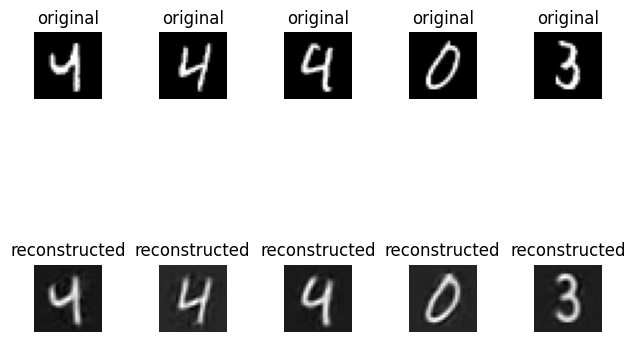

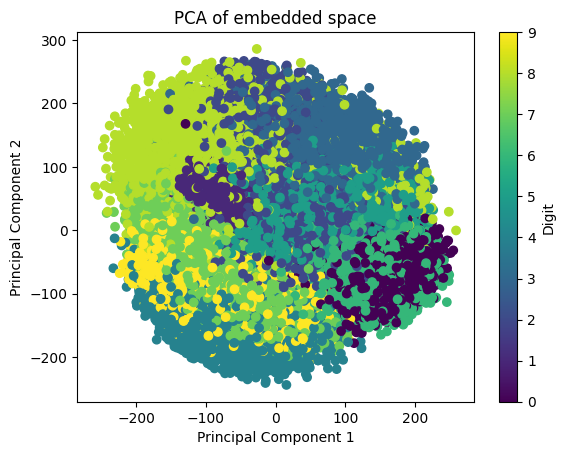

fitted pca
fitting umap


AttributeError: module 'umap' has no attribute 'UMAP'

<Figure size 640x480 with 0 Axes>

In [25]:
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/pretrained_AE_test.pth"))
autoencoder.fitted = True
visualize_peformance_AE(autoencoder, dataset, labels, (28,28), 5)

visualize_peformance_AE(dipect.autoencoder, dataset, labels, (28,28), 5)

In [81]:
import networkx as nx
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from clustpy.deep._utils import encode_batchwise
from clustpy.deep._data_utils import get_dataloader

def graphviz_layout_binary_tree(G, root):
    A = nx.nx_agraph.to_agraph(G)
    A.layout(prog='dot')  # 'dot' is used for hierarchical layouts
    pos = {}
    for node in G.nodes():
        x, y = A.get_node(node).attr['pos'].split(',')
        pos[node] = (float(x), float(y))
    return pos

def build_and_visualize_tree(root, autoencoder, data):
    if root is None:
        return
    testloader = get_dataloader(data, 256, False, False)
    embedded_data = encode_batchwise(testloader, autoencoder, "cpu")
    embedded_data = torch.from_numpy(embedded_data)

    # Create a directed graph
    G = nx.DiGraph()
    
    # Helper function to add nodes and edges to the graph
    def add_edges(G, node):
        if node.left_child:
            G.add_edge(node, node.left_child)
            add_edges(G, node.left_child)
        if node.right_child:
            G.add_edge(node, node.right_child)
            add_edges(G, node.right_child)
    
    # Add nodes and edges starting from the root
    add_edges(G, root)

    # Create a position dictionary for the nodes
    pos = graphviz_layout_binary_tree(G, root)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 15))
    nx.draw(G, pos, ax=ax, with_labels=False)
    
    # Draw the images at the nodes
    for node in G.nodes:
        image = np.mean(autoencoder.decode(embedded_data[node.assigned_indices]).detach().numpy(), axis=0)
        if np.max(image) <= 1:
            image = image*255
        # image = autoencoder.decode(center).detach().numpy()
        image = image.reshape(28,28)
        
        # if dataset_type == DatasetType.USPS:
        #     image = image.reshape(16,16)
        # else:
        #     image = image.reshape(28,28)
        imagebox = OffsetImage(image, zoom=1)
        ab = AnnotationBbox(imagebox, pos[node], frameon=False)
        ax.add_artist(ab)
    
    plt.show()

from PIL import Image, ImageDraw, ImageFont

def integer_to_image(number, font_size=10, image_size=(28, 28), bg_color=(255, 255, 255), text_color=(0, 0, 0)):
    image = Image.new('RGB', image_size, bg_color)
    
    
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    text = str(number)
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]
    
  
    position = ((image_size[0] - text_width) / 2, (image_size[1] - text_height) / 2)
    

    draw.text(position, text, fill=text_color, font=font)
    
    return np.array(image)


def build_and_visualize_splitindex_tree(root):
    if root is None:
        return

    # Create a directed graph
    G = nx.DiGraph()
    
    # Helper function to add nodes and edges to the graph
    def add_edges(G, node):
        if node.left_child:
            G.add_edge(node, node.left_child)
            add_edges(G, node.left_child)
        if node.right_child:
            G.add_edge(node, node.right_child)
            add_edges(G, node.right_child)
    
    # Add nodes and edges starting from the root
    add_edges(G, root)

    # Create a position dictionary for the nodes
    pos = graphviz_layout_binary_tree(G, root)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 15))
    nx.draw(G, pos, ax=ax, with_labels=False)
    
    # Draw the images at the nodes
    for node in G.nodes:
        image = integer_to_image(node.split_id)
        # image = autoencoder.decode(center).detach().numpy()
        # image = image.reshape(28,28)
        
        # if dataset_type == DatasetType.USPS:
        #     image = image.reshape(16,16)
        # else:
        #     image = image.reshape(28,28)
        imagebox = OffsetImage(image, zoom=1)
        ab = AnnotationBbox(imagebox, pos[node], frameon=False)
        ax.add_artist(ab)
    
    plt.show()
# def visualize_cluster_tree(dataset_type: DatasetType, autoencoder_type: AutoencoderType):
#     dataset = get_dataset(dataset_type)

#     data = dataset["data"]
#     labels = dataset["target"]

#     autoencoder = pretraining(autoencoder_type, None, dataset, 42, 10)

#     deepect = deepect_paper.DeepECT(
#         autoencoder=autoencoder,
#         clustering_optimizer_params={"lr": 1e-4, "betas": (0.9, 0.999)},
#         max_leaf_nodes=20,
#         random_state=np.random.RandomState(42),
#     )

#     deepect.fit_predict(data)

#     print("Accuracy: ", deepect.tree_.flat_accuracy(labels, 10))

#     build_and_visualize_tree(deepect.tree_.root, autoencoder, dataset_type)

In [33]:
build_and_visualize_tree(dipect.tree_.root, dipect.autoencoder, dataset)

ImportError: requires pygraphviz http://pygraphviz.github.io/

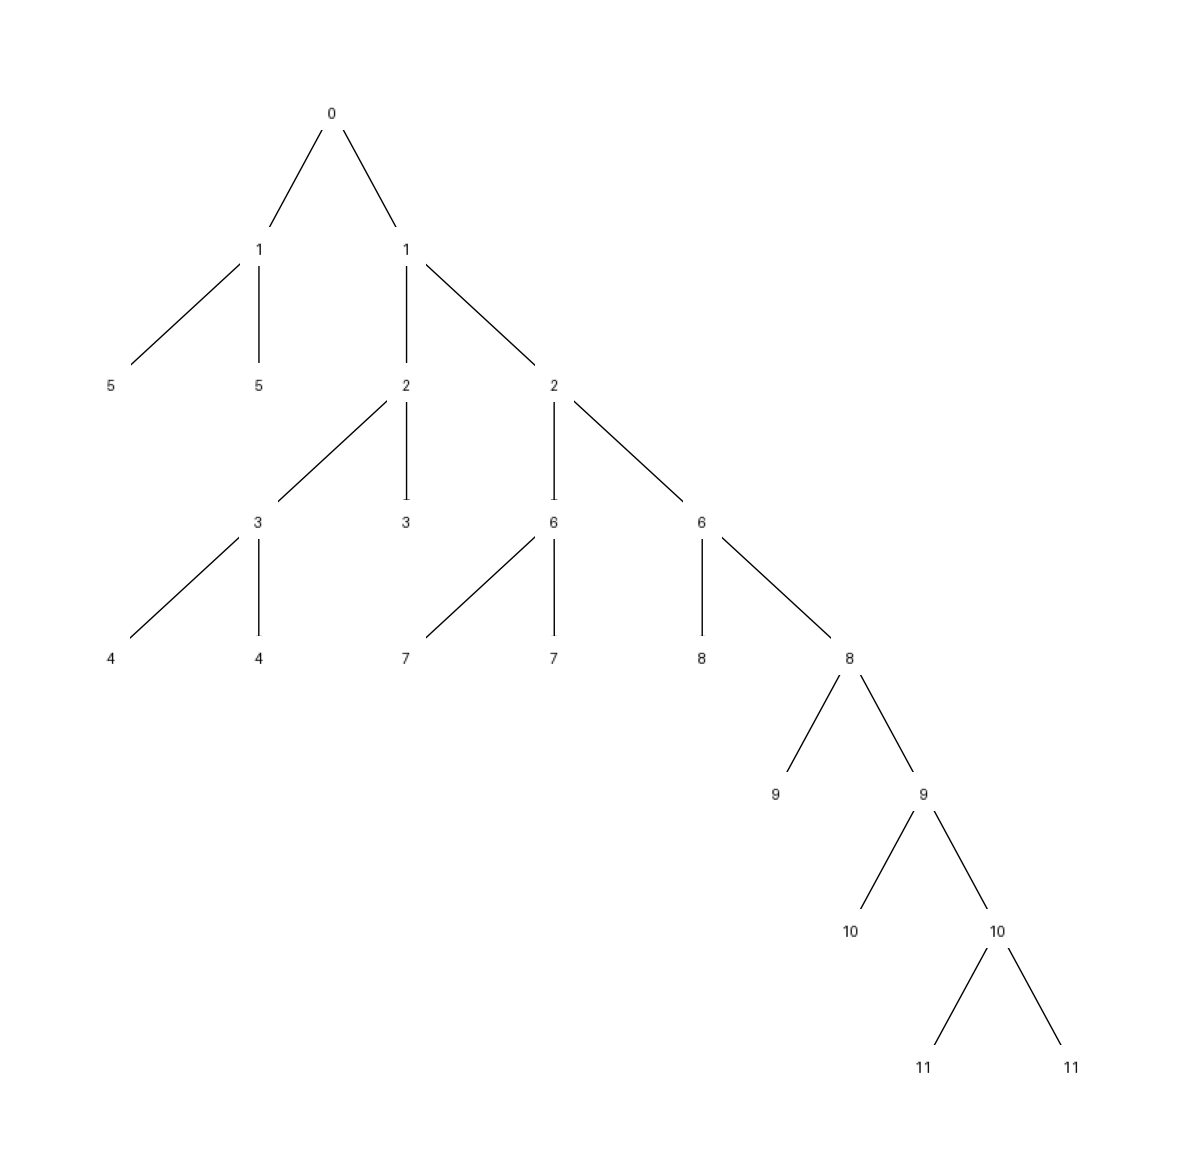

In [39]:
build_and_visualize_splitindex_tree(dipect.tree_.root)

/home/schilcherj/master/deepClustering/deepClustEnv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/schilcherj/master/deepClustering/deepClustEnv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


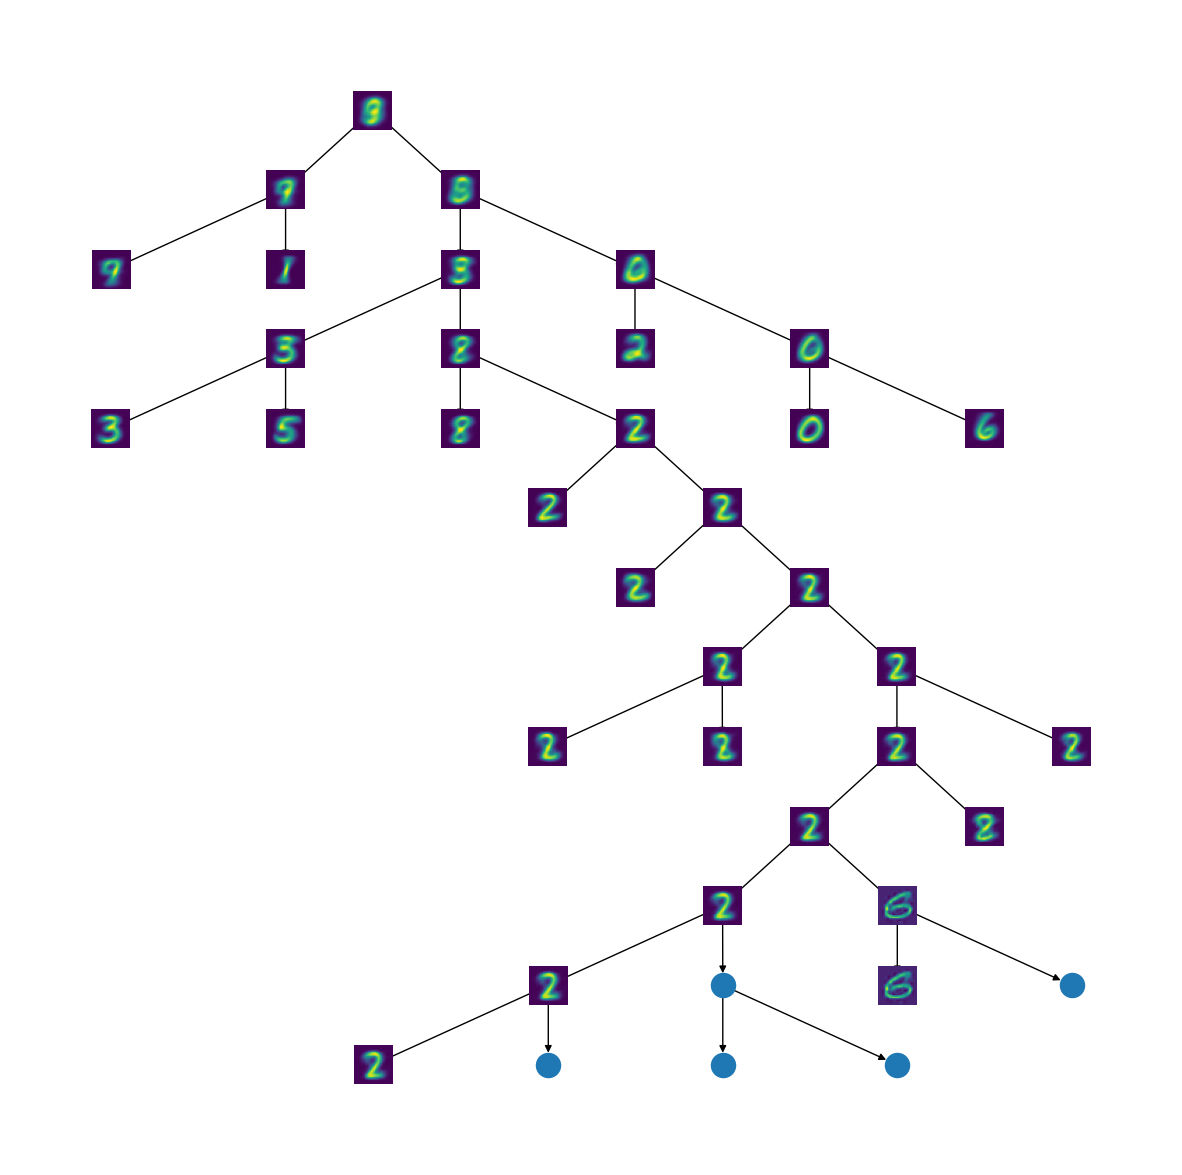

In [32]:
build_and_visualize_tree(dipect_bigger_tree.tree_.root, dipect_bigger_tree.autoencoder, dataset)

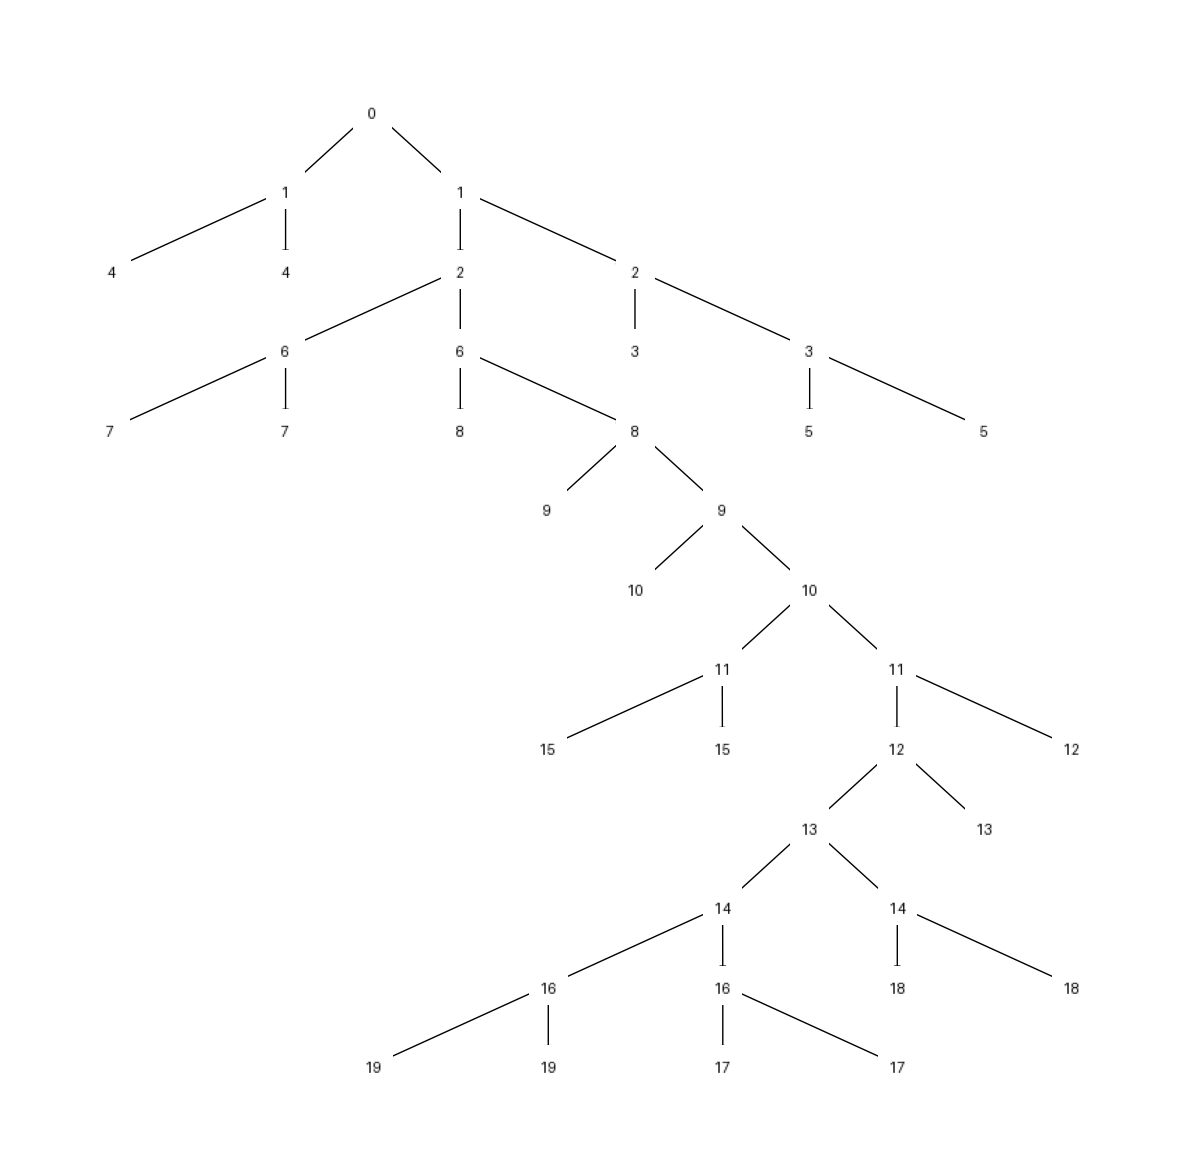

In [40]:
build_and_visualize_splitindex_tree(dipect_bigger_tree.tree_.root)

/home/schilcherj/master/deepClustering/deepClustEnv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/schilcherj/master/deepClustering/deepClustEnv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


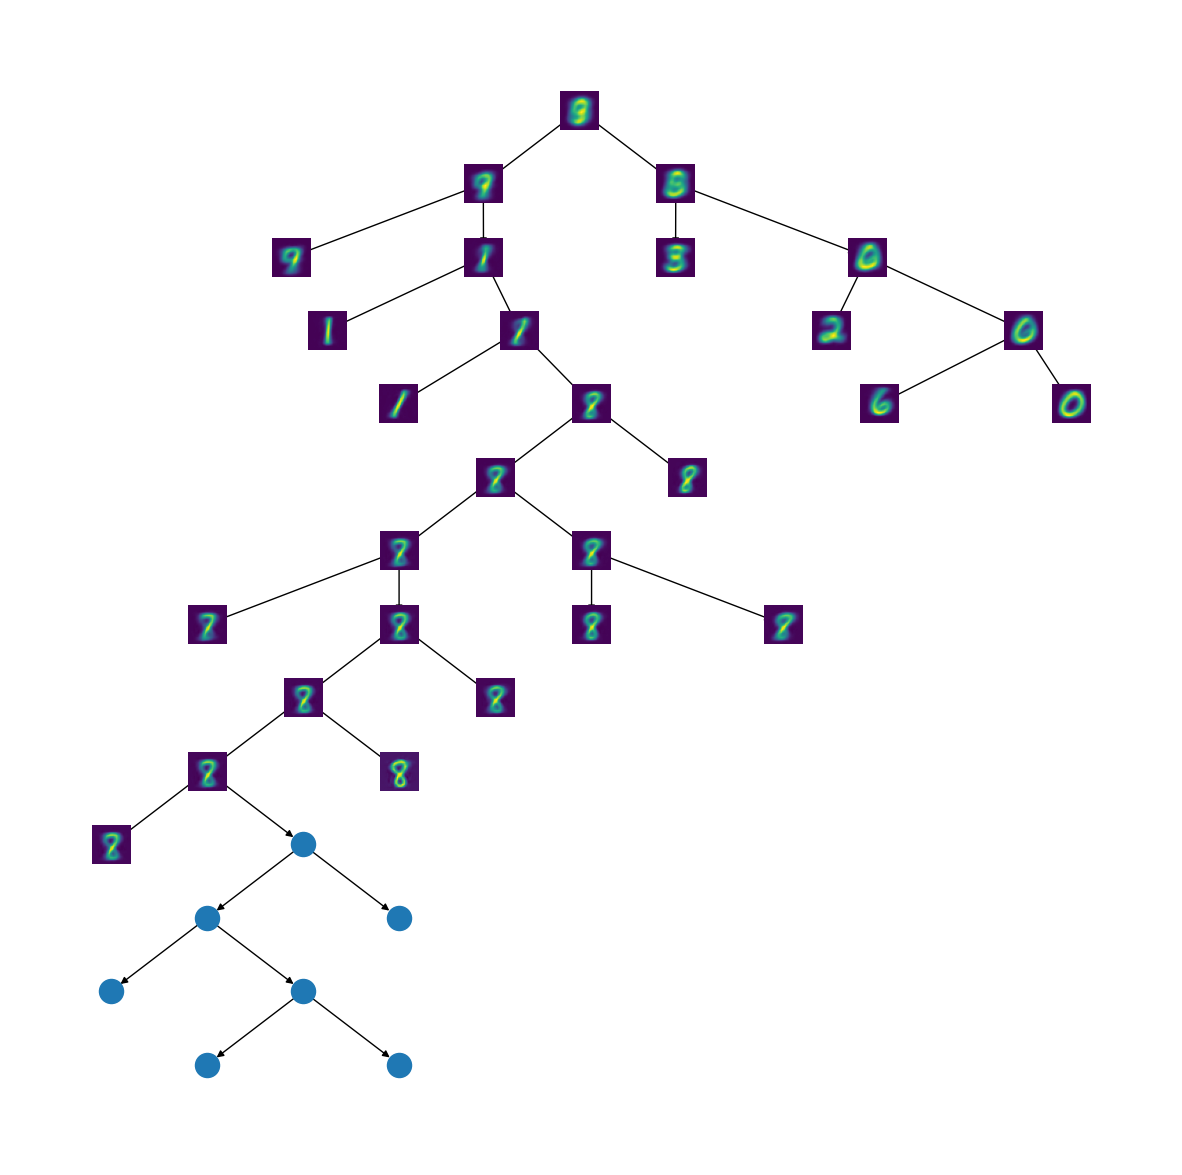

In [44]:
build_and_visualize_tree(dipect_view_iterations.tree_.root, dipect_view_iterations.autoencoder, dataset)

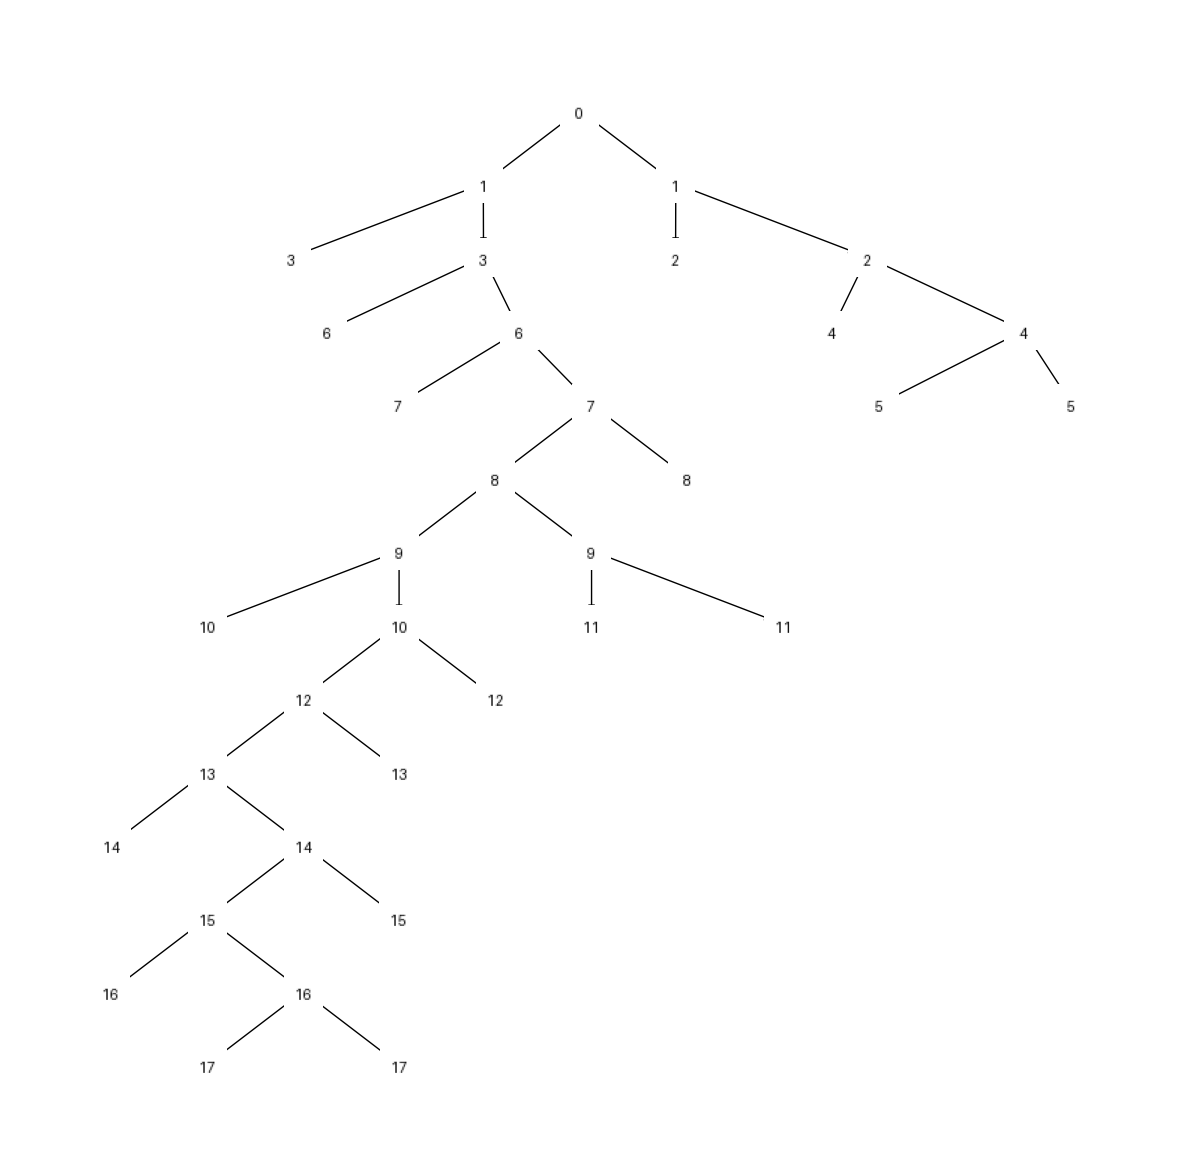

In [45]:
build_and_visualize_splitindex_tree(dipect_view_iterations.tree_.root)


In [49]:
dataset, labels = load_mnist(return_X_y=True)
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/pretrained_AE.pth"))
autoencoder.fitted = True

dipect_test = DipECT(autoencoder=autoencoder, grow_interval=100, max_iterations=2000)
dipect_test = dipect_test.fit_predict(dataset)

cpu


Fit:   5%|▌         | 100/2000 [00:12<04:18,  7.35it/s]

#assignments:  28926
#assignments:  31074
#assignments best node:  28926


Fit:  10%|█         | 200/2000 [00:35<03:41,  8.13it/s]  

#assignments:  10202
#assignments:  17271
#assignments:  32527
#assignments best node:  32527


Fit:  15%|█▌        | 300/2000 [01:00<04:05,  6.93it/s]  

#assignments:  9662
#assignments:  17503
#assignments:  15802
#assignments:  17033
#assignments best node:  15802


Fit:  20%|██        | 400/2000 [01:26<03:43,  7.15it/s]  

#assignments:  8779
#assignments:  17488
#assignments:  9484
#assignments:  7319
#assignments:  16930
#assignments best node:  9484


Fit:  25%|██▌       | 500/2000 [01:53<03:42,  6.73it/s]  

#assignments:  8116
#assignments:  17606
#assignments:  5036
#assignments:  5309
#assignments:  7226
#assignments:  16707
#assignments best node:  16707


Fit:  30%|███       | 600/2000 [02:20<03:51,  6.04it/s]  

#assignments:  8224
#assignments:  17586
#assignments:  5060
#assignments:  5223
#assignments:  7428
#assignments:  4016
#assignments:  12463
#assignments best node:  7428


Fit:  35%|███▌      | 700/2000 [02:49<03:09,  6.87it/s]  

#assignments:  7848
#assignments:  17619
#assignments:  4932
#assignments:  5233
#assignments:  6335
#assignments:  1310
#assignments:  4355
#assignments:  12368
#assignments best node:  12368


Fit:  40%|████      | 800/2000 [03:27<07:35,  2.63it/s]  

#assignments:  7703
#assignments:  17621
#assignments:  5114
#assignments:  5364
#assignments:  6291
#assignments:  1303
#assignments:  4330
#assignments:  6305
#assignments:  5969
#assignments best node:  1303


Fit:  45%|████▌     | 900/2000 [04:07<03:34,  5.13it/s]  

#assignments:  7572
#assignments:  17707
#assignments:  5121
#assignments:  5341
#assignments:  6313
#assignments:  802
#assignments:  656
#assignments:  4304
#assignments:  6305
#assignments:  5879
#assignments best node:  656


Fit:  50%|█████     | 1000/2000 [04:42<03:05,  5.40it/s] 

#assignments:  7586
#assignments:  17646
#assignments:  5132
#assignments:  5327
#assignments:  6259
#assignments:  796
#assignments:  412
#assignments:  397
#assignments:  4302
#assignments:  6246
#assignments:  5897
#assignments best node:  412


Fit:  55%|█████▌    | 1100/2000 [05:13<02:12,  6.77it/s]  

#assignments:  7482
#assignments:  17801
#assignments:  5131
#assignments:  5348
#assignments:  6232
#assignments:  624
#assignments:  169
#assignments:  321
#assignments:  520
#assignments:  4278
#assignments:  6218
#assignments:  5876
#assignments best node:  321


Fit:  60%|██████    | 1200/2000 [05:44<02:14,  5.96it/s]  

#assignments:  7451
#assignments:  17789
#assignments:  5181
#assignments:  5393
#assignments:  6231
#assignments:  1042
#assignments:  113
#assignments:  43
#assignments:  51
#assignments:  338
#assignments:  4287
#assignments:  6250
#assignments:  5831
#assignments best node:  43


Fit:  65%|██████▌   | 1300/2000 [06:26<02:22,  4.92it/s]  

#assignments:  7530
#assignments:  17768
#assignments:  5181
#assignments:  5396
#assignments:  6241
#assignments:  470
#assignments:  163
#assignments:  112
#assignments:  181
#assignments:  183
#assignments:  480
#assignments:  4254
#assignments:  6211
#assignments:  5830
#assignments best node:  112


Fit:  70%|███████   | 1400/2000 [06:59<01:38,  6.08it/s]

#assignments:  7389
#assignments:  17926
#assignments:  5162
#assignments:  5349
#assignments:  6279
#assignments:  584
#assignments:  156
#assignments:  26
#assignments:  24
#assignments:  24
#assignments:  174
#assignments:  599
#assignments:  4311
#assignments:  6176
#assignments:  5821
#assignments best node:  24


Fit:  75%|███████▌  | 1500/2000 [07:31<01:21,  6.11it/s]

#assignments:  7379
#assignments:  17796
#assignments:  5264
#assignments:  5408
#assignments:  6186
#assignments:  484
#assignments:  247
#assignments:  15
#assignments:  52
#assignments:  32
#assignments:  16
#assignments:  132
#assignments:  667
#assignments:  4340
#assignments:  6188
#assignments:  5794
#assignments best node:  16


Fit:  80%|████████  | 1600/2000 [08:02<01:02,  6.38it/s]

#assignments:  7361
#assignments:  17863
#assignments:  5249
#assignments:  5396
#assignments:  6193
#assignments:  1133
#assignments:  57
#assignments:  24
#assignments:  18
#assignments:  14
#assignments:  5
#assignments:  5
#assignments:  34
#assignments:  293
#assignments:  4363
#assignments:  6194
#assignments:  5798
#assignments best node:  18


Fit:  85%|████████▌ | 1700/2000 [08:44<00:55,  5.40it/s]

#assignments:  7367
#assignments:  17832
#assignments:  5230
#assignments:  5383
#assignments:  6259
#assignments:  902
#assignments:  166
#assignments:  7
#assignments:  9
#assignments:  5
#assignments:  23
#assignments:  11
#assignments:  9
#assignments:  172
#assignments:  399
#assignments:  4280
#assignments:  6169
#assignments:  5777
#assignments best node:  9


Fit:  90%|█████████ | 1800/2000 [09:32<00:42,  4.71it/s]

#assignments:  7328
#assignments:  17872
#assignments:  5163
#assignments:  5393
#assignments:  6280
#assignments:  598
#assignments:  318
#assignments:  35
#assignments:  7
#assignments:  9
#assignments:  8
#assignments:  10
#assignments:  29
#assignments:  9
#assignments:  170
#assignments:  519
#assignments:  4303
#assignments:  6153
#assignments:  5796
#assignments best node:  10


Fit: 2001it [11:28,  2.91it/s]                          
Predict: 100%|██████████| 235/235 [00:11<00:00, 20.43it/s]


In [50]:
print(dipect_test.tree_.flat_accuracy(labels, 10))
print(dipect_test.tree_.flat_nmi(labels, 10))

0.7232
0.7757994560891956


In [58]:
dataset, labels = load_mnist(return_X_y=True)
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/pretrained_AE.pth"))
autoencoder.fitted = True

dipect_test_2 = DipECT(autoencoder=autoencoder, grow_interval=200, max_iterations=10000, consider_num_assignments_for_growing=True)
dipect_test_2 = dipect_test_2.fit_predict(dataset)

cpu


Fit:   2%|▏         | 200/10000 [02:51<1:58:24,  1.38it/s]

inside
#assignments:  28806
#assignments:  31194
#assignments best node:  31194


Fit:   4%|▍         | 400/10000 [06:30<3:38:49,  1.37s/it] 

inside
#assignments:  28567
#assignments:  16378
#assignments:  15055
#assignments best node:  28567


Fit:   6%|▌         | 600/10000 [09:36<1:37:35,  1.61it/s] 

inside
#assignments:  9561
#assignments:  17909
#assignments:  16332
#assignments:  16198
#assignments best node:  16198


Fit:   8%|▊         | 800/10000 [11:51<1:24:13,  1.82it/s] 

inside
#assignments:  9823
#assignments:  17775
#assignments:  16422
#assignments:  8674
#assignments:  7306
#assignments best node:  17775


Fit:  10%|█         | 1000/10000 [14:01<1:23:21,  1.80it/s]

inside
#assignments:  9397
#assignments:  5875
#assignments:  11832
#assignments:  16272
#assignments:  9464
#assignments:  7160
#assignments best node:  9464


Fit:  12%|█▏        | 1200/10000 [16:18<1:19:09,  1.85it/s] 

inside
#assignments:  9383
#assignments:  5862
#assignments:  11810
#assignments:  16262
#assignments:  4041
#assignments:  5370
#assignments:  7272
#assignments best node:  16262


Fit:  14%|█▍        | 1400/10000 [18:32<1:19:05,  1.81it/s] 

inside
#assignments:  8861
#assignments:  5932
#assignments:  11828
#assignments:  12023
#assignments:  4208
#assignments:  4399
#assignments:  5382
#assignments:  7367
#assignments best node:  12023


Fit:  16%|█▌        | 1600/10000 [20:53<1:19:28,  1.76it/s] 

inside
#assignments:  8920
#assignments:  5985
#assignments:  11787
#assignments:  6236
#assignments:  5741
#assignments:  4239
#assignments:  4258
#assignments:  5382
#assignments:  7452
#assignments best node:  7452


Fit:  18%|█▊        | 1800/10000 [23:05<1:21:04,  1.69it/s] 

inside
#assignments:  9136
#assignments:  5994
#assignments:  11872
#assignments:  6181
#assignments:  5736
#assignments:  4249
#assignments:  3919
#assignments:  5389
#assignments:  6306
#assignments:  1218
#assignments best node:  11872


Fit:  20%|██        | 2000/10000 [25:35<1:33:38,  1.42it/s] 

inside
#assignments:  8852
#assignments:  6038
#assignments:  6275
#assignments:  5488
#assignments:  6220
#assignments:  5712
#assignments:  4271
#assignments:  4169
#assignments:  5422
#assignments:  6228
#assignments:  1325
#assignments best node:  5488


Fit:  22%|██▏       | 2200/10000 [28:18<1:17:42,  1.67it/s] 

inside
#assignments:  9042
#assignments:  6101
#assignments:  6162
#assignments:  2542
#assignments:  2958
#assignments:  6189
#assignments:  5690
#assignments:  4328
#assignments:  3987
#assignments:  5449
#assignments:  6216
#assignments:  1336
#assignments best node:  6162


Fit:  24%|██▍       | 2400/10000 [30:42<1:22:29,  1.54it/s] 

inside
#assignments:  8822
#assignments:  6223
#assignments:  3111
#assignments:  2974
#assignments:  2629
#assignments:  2909
#assignments:  6169
#assignments:  5762
#assignments:  4371
#assignments:  3993
#assignments:  5396
#assignments:  6235
#assignments:  1406
#assignments best node:  8822


Fit:  26%|██▌       | 2600/10000 [33:25<1:16:56,  1.60it/s] 

inside
#assignments:  3647
#assignments:  4895
#assignments:  6156
#assignments:  3078
#assignments:  2943
#assignments:  2686
#assignments:  2957
#assignments:  6145
#assignments:  5720
#assignments:  4351
#assignments:  4244
#assignments:  5392
#assignments:  6259
#assignments:  1527
#assignments best node:  4895


Fit:  28%|██▊       | 2800/10000 [35:58<1:12:26,  1.66it/s] 

inside
#assignments:  3704
#assignments:  3481
#assignments:  1494
#assignments:  6146
#assignments:  3099
#assignments:  2970
#assignments:  2642
#assignments:  2907
#assignments:  6120
#assignments:  5748
#assignments:  4359
#assignments:  4228
#assignments:  5374
#assignments:  6203
#assignments:  1525
#assignments best node:  6146


Fit:  30%|███       | 3000/10000 [37:37<25:54,  4.50it/s]   

inside
#assignments:  3880
#assignments:  3234
#assignments:  1086
#assignments:  1786
#assignments:  4422
#assignments:  3078
#assignments:  2936
#assignments:  2677
#assignments:  2933
#assignments:  6104
#assignments:  5768
#assignments:  4368
#assignments:  4603
#assignments:  5390
#assignments:  6211
#assignments:  1524
#assignments best node:  6211


Fit:  32%|███▏      | 3200/10000 [38:25<16:37,  6.81it/s]   

inside
#assignments:  3771
#assignments:  3361
#assignments:  1451
#assignments:  1695
#assignments:  4541
#assignments:  3096
#assignments:  2940
#assignments:  2712
#assignments:  2924
#assignments:  6091
#assignments:  5743
#assignments:  4358
#assignments:  4184
#assignments:  5377
#assignments:  2609
#assignments:  3642
#assignments:  1505
#assignments best node:  6091


Fit:  34%|███▍      | 3400/10000 [39:16<15:42,  7.00it/s]   

inside
#assignments:  3818
#assignments:  3310
#assignments:  1219
#assignments:  1728
#assignments:  4475
#assignments:  3000
#assignments:  2909
#assignments:  2716
#assignments:  2943
#assignments:  3172
#assignments:  2910
#assignments:  5762
#assignments:  4408
#assignments:  4455
#assignments:  5369
#assignments:  3483
#assignments:  2787
#assignments:  1536
#assignments best node:  5762


Fit:  36%|███▌      | 3600/10000 [40:11<16:01,  6.66it/s]   

inside
#assignments:  3836
#assignments:  3331
#assignments:  1419
#assignments:  1841
#assignments:  4363
#assignments:  2946
#assignments:  2871
#assignments:  2763
#assignments:  2965
#assignments:  2609
#assignments:  3467
#assignments:  2721
#assignments:  3028
#assignments:  4374
#assignments:  4321
#assignments:  5377
#assignments:  3312
#assignments:  2912
#assignments:  1544
#assignments best node:  5377


Fit: 10001it [1:02:45,  2.66it/s]                           
Predict: 100%|██████████| 235/235 [00:05<00:00, 42.84it/s]


In [59]:
print(dipect_test_2.tree_.flat_accuracy(labels, 10))
print(dipect_test_2.tree_.flat_nmi(labels, 10))

0.8225333333333333
0.8341760347557395


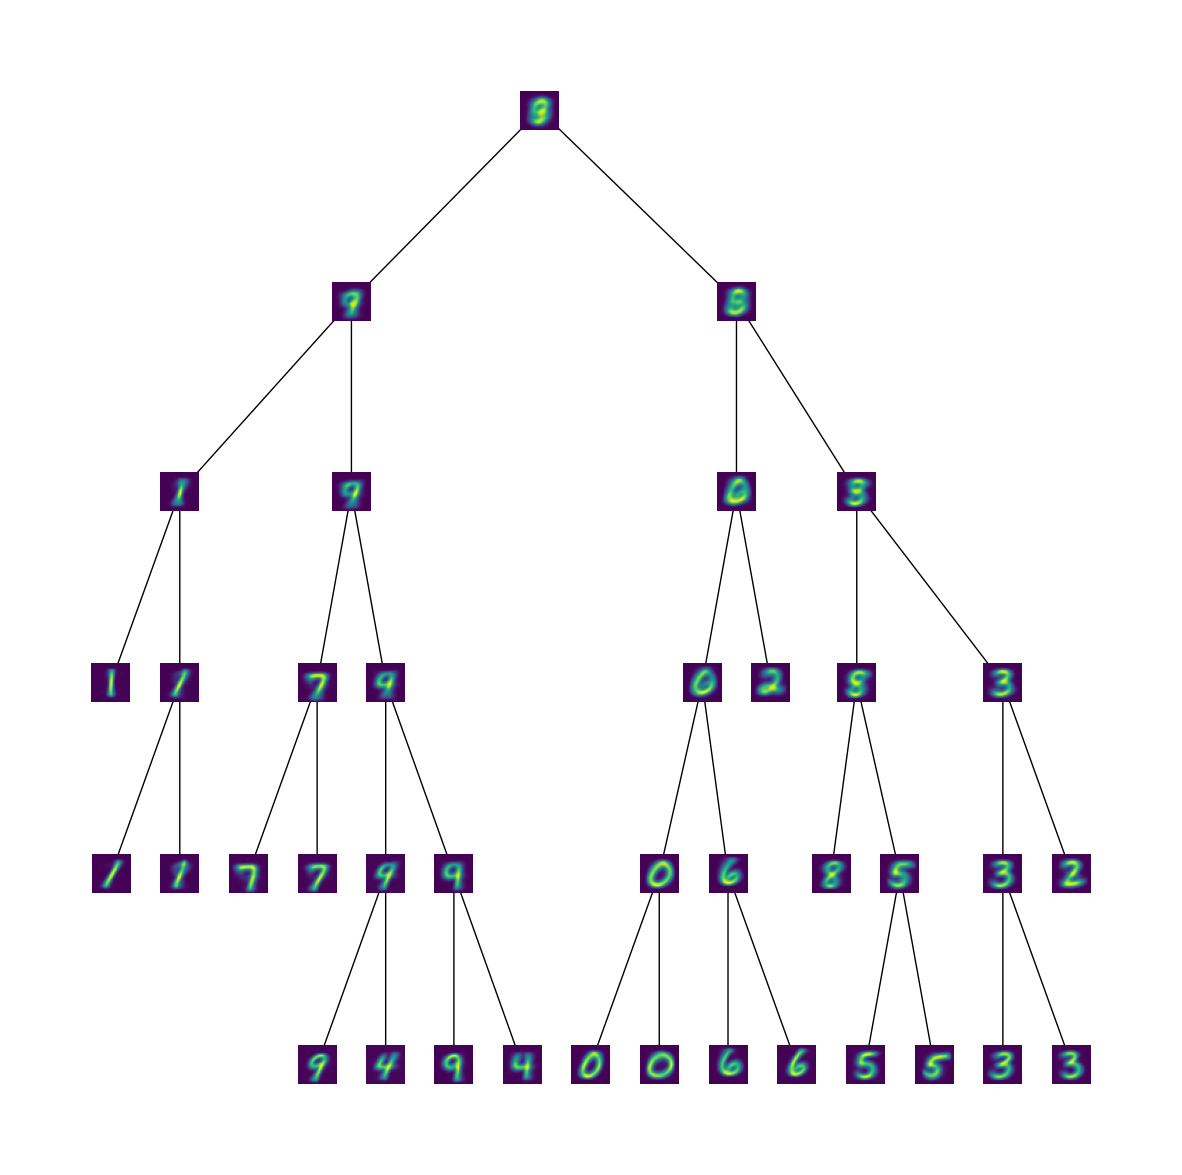

In [60]:
build_and_visualize_tree(dipect_test_2.tree_.root, dipect_test_2.autoencoder, dataset)

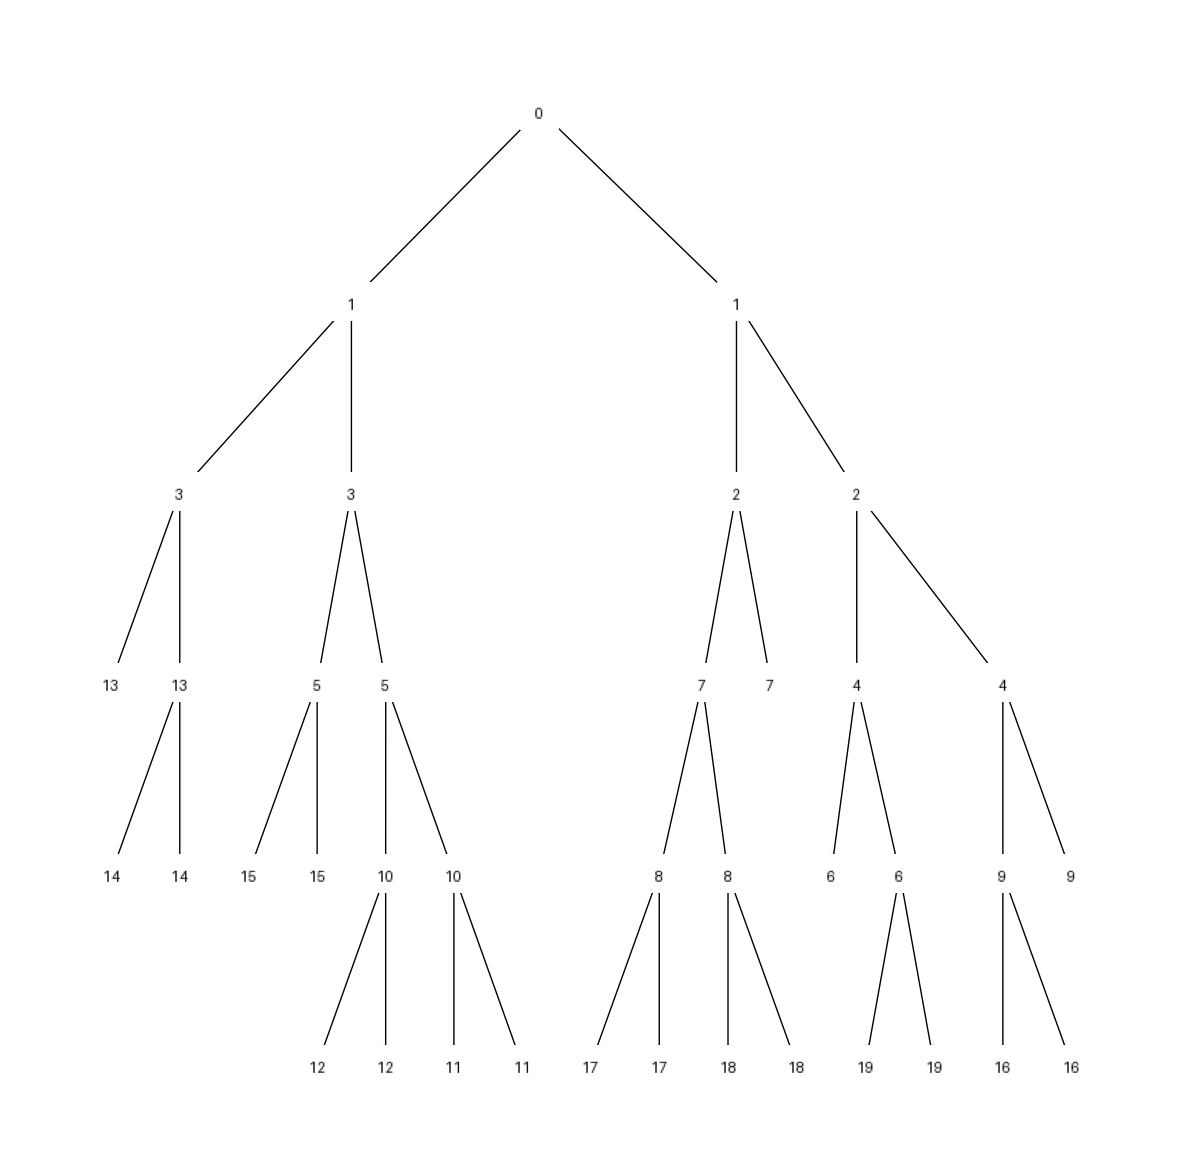

In [61]:
build_and_visualize_splitindex_tree(dipect_test_2.tree_.root)

fitting pca


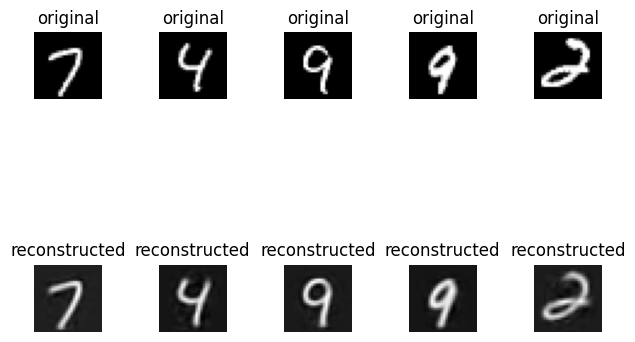

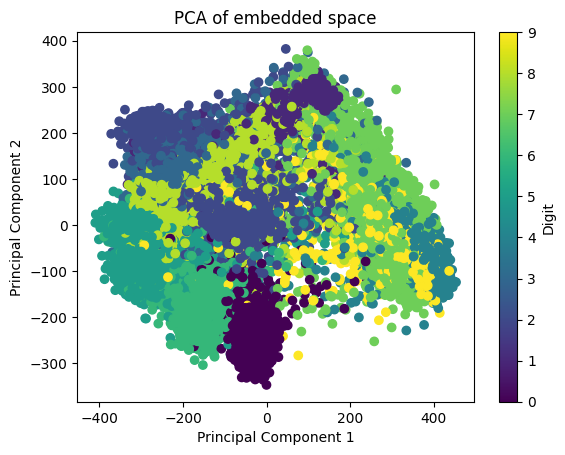

fitted pca
fitting umap


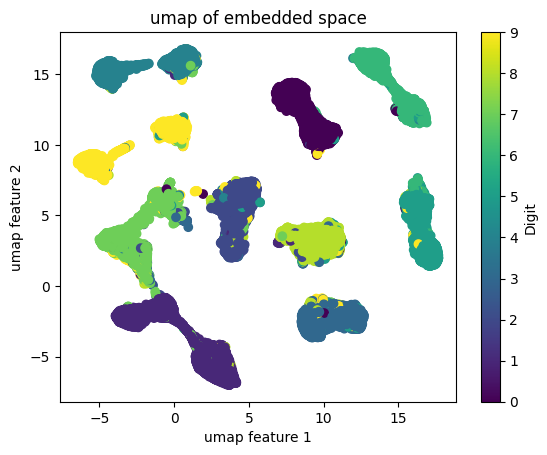

fitted umap


In [62]:
visualize_peformance_AE(dipect_test_2.autoencoder, dataset, labels, (28,28), 5)

In [176]:

autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/pretrained_AE.pth"))
autoencoder.fitted = True

dipect_test = DipECT(autoencoder=autoencoder, grow_interval=400, max_iterations=8000, consider_num_assignments_for_growing=True)
dipect_test = dipect_test.fit_predict(dataset)

cpu


Fit:   5%|▍         | 399/8000 [00:36<11:48, 10.73it/s]

inside
#assignments:  27012
#assignments:  32988
#assignments best node:  32988


Fit:  10%|█         | 800/8000 [01:27<11:11, 10.72it/s]  

inside
#assignments:  25918
#assignments:  17393
#assignments:  16689
#assignments best node:  25918


Fit:  15%|█▍        | 1199/8000 [02:12<09:51, 11.50it/s] 

inside
#assignments:  7518
#assignments:  18144
#assignments:  17834
#assignments:  16504
#assignments best node:  17834


Fit:  20%|█▉        | 1599/8000 [03:05<11:50,  9.02it/s]  

inside
#assignments:  7284
#assignments:  17980
#assignments:  6690
#assignments:  11626
#assignments:  16420
#assignments best node:  11626


Fit:  25%|██▌       | 2000/8000 [04:16<24:41,  4.05it/s]  

inside
#assignments:  7181
#assignments:  18017
#assignments:  7021
#assignments:  5497
#assignments:  5992
#assignments:  16292
#assignments best node:  18017


Fit:  30%|███       | 2400/8000 [05:42<10:32,  8.85it/s]  

inside
#assignments:  7100
#assignments:  10379
#assignments:  7555
#assignments:  7178
#assignments:  5459
#assignments:  6042
#assignments:  16287
#assignments best node:  16287


Fit:  35%|███▍      | 2799/8000 [07:24<10:10,  8.52it/s]  

inside
#assignments:  7079
#assignments:  10242
#assignments:  7743
#assignments:  7089
#assignments:  5529
#assignments:  6007
#assignments:  5766
#assignments:  10545
#assignments best node:  10545


Fit:  40%|████      | 3200/8000 [09:15<12:44,  6.28it/s]  

inside
#assignments:  7058
#assignments:  10318
#assignments:  7777
#assignments:  7186
#assignments:  5520
#assignments:  5958
#assignments:  5810
#assignments:  4199
#assignments:  6174
#assignments best node:  10318


Fit:  45%|████▍     | 3599/8000 [11:14<07:27,  9.83it/s]  

inside
#assignments:  7004
#assignments:  4274
#assignments:  5870
#assignments:  7824
#assignments:  7256
#assignments:  5521
#assignments:  6018
#assignments:  5838
#assignments:  4246
#assignments:  6149
#assignments best node:  7256


Fit:  50%|█████     | 4000/8000 [13:14<14:36,  4.56it/s]  

inside
#assignments:  7031
#assignments:  4253
#assignments:  5874
#assignments:  7923
#assignments:  5558
#assignments:  1611
#assignments:  5496
#assignments:  5986
#assignments:  5876
#assignments:  4259
#assignments:  6133
#assignments best node:  7923


Fit:  55%|█████▌    | 4400/8000 [15:05<11:38,  5.15it/s]  

inside
#assignments:  7000
#assignments:  4368
#assignments:  5836
#assignments:  3891
#assignments:  4001
#assignments:  5542
#assignments:  1631
#assignments:  5468
#assignments:  5949
#assignments:  5927
#assignments:  4270
#assignments:  6117
#assignments best node:  7000


Fit:  60%|██████    | 4800/8000 [17:10<44:51,  1.19it/s]  

inside
#assignments:  3403
#assignments:  3603
#assignments:  4404
#assignments:  5822
#assignments:  3797
#assignments:  4013
#assignments:  5639
#assignments:  1611
#assignments:  5439
#assignments:  5936
#assignments:  5913
#assignments:  4343
#assignments:  6077
#assignments best node:  5913


Fit:  65%|██████▌   | 5200/8000 [20:37<27:46,  1.68it/s]   

inside
#assignments:  3435
#assignments:  3602
#assignments:  4406
#assignments:  5826
#assignments:  3792
#assignments:  3949
#assignments:  5689
#assignments:  1637
#assignments:  5492
#assignments:  5972
#assignments:  3209
#assignments:  2670
#assignments:  4280
#assignments:  6041
#assignments best node:  5689


Fit:  70%|███████   | 5600/8000 [21:43<04:21,  9.18it/s]  

inside
#assignments:  3334
#assignments:  3668
#assignments:  4496
#assignments:  5812
#assignments:  3676
#assignments:  4029
#assignments:  3361
#assignments:  2282
#assignments:  1636
#assignments:  5515
#assignments:  5947
#assignments:  3140
#assignments:  2747
#assignments:  4345
#assignments:  6012
#assignments best node:  6012


Fit:  75%|███████▌  | 6000/8000 [22:47<04:15,  7.82it/s]  

inside
#assignments:  3365
#assignments:  3626
#assignments:  4477
#assignments:  5806
#assignments:  3674
#assignments:  3990
#assignments:  3301
#assignments:  2380
#assignments:  1634
#assignments:  5507
#assignments:  5981
#assignments:  2918
#assignments:  2946
#assignments:  4356
#assignments:  2778
#assignments:  3261
#assignments best node:  5981


Fit:  80%|████████  | 6400/8000 [24:24<03:12,  8.30it/s]  

inside
#assignments:  3414
#assignments:  3616
#assignments:  4487
#assignments:  5802
#assignments:  3720
#assignments:  3977
#assignments:  2736
#assignments:  2943
#assignments:  1650
#assignments:  5448
#assignments:  3028
#assignments:  2938
#assignments:  2996
#assignments:  2880
#assignments:  4324
#assignments:  2854
#assignments:  3187
#assignments best node:  5802


Fit:  85%|████████▌ | 6800/8000 [26:34<02:34,  7.75it/s]  

inside
#assignments:  3460
#assignments:  3538
#assignments:  4373
#assignments:  2310
#assignments:  3482
#assignments:  3846
#assignments:  3965
#assignments:  2753
#assignments:  2940
#assignments:  1634
#assignments:  5456
#assignments:  4104
#assignments:  1859
#assignments:  2980
#assignments:  2937
#assignments:  4368
#assignments:  2716
#assignments:  3279
#assignments best node:  5456


Fit:  90%|█████████ | 7200/8000 [30:25<04:26,  3.00it/s]  

inside
#assignments:  3354
#assignments:  3631
#assignments:  4452
#assignments:  2473
#assignments:  3310
#assignments:  3759
#assignments:  4004
#assignments:  3032
#assignments:  2685
#assignments:  1690
#assignments:  3011
#assignments:  2449
#assignments:  2761
#assignments:  3206
#assignments:  3008
#assignments:  2878
#assignments:  4293
#assignments:  2784
#assignments:  3220
#assignments best node:  4293


Fit: 8001it [34:01,  3.92it/s]                            
Predict: 100%|██████████| 235/235 [00:07<00:00, 30.17it/s]


In [177]:
print(dipect_test.tree_.flat_accuracy(labels, 10))
print(dipect_test.tree_.flat_nmi(labels, 10))

0.9113333333333333
0.8508044991636202


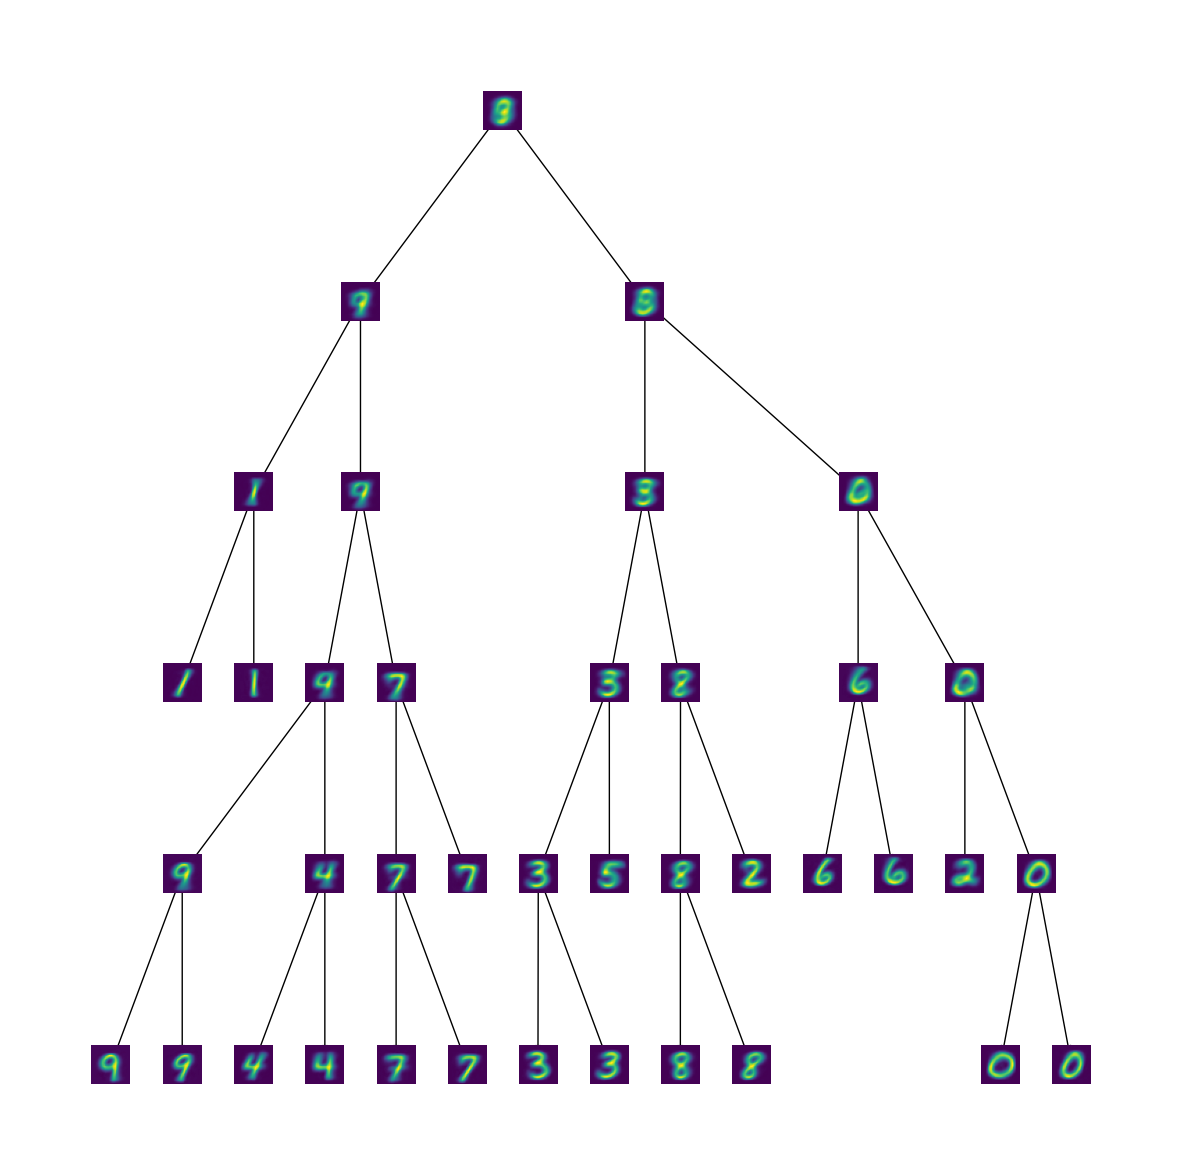

In [175]:
build_and_visualize_tree(dipect_test.tree_.root, dipect_test.autoencoder, dataset)

fitting pca


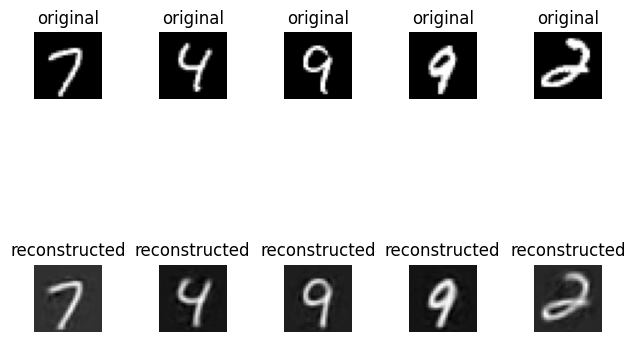

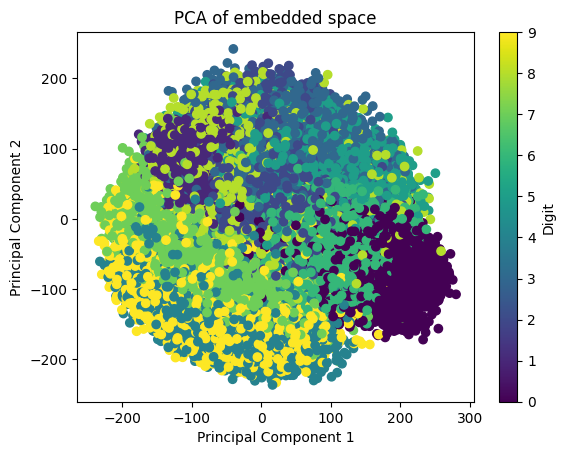

fitted pca
fitting umap


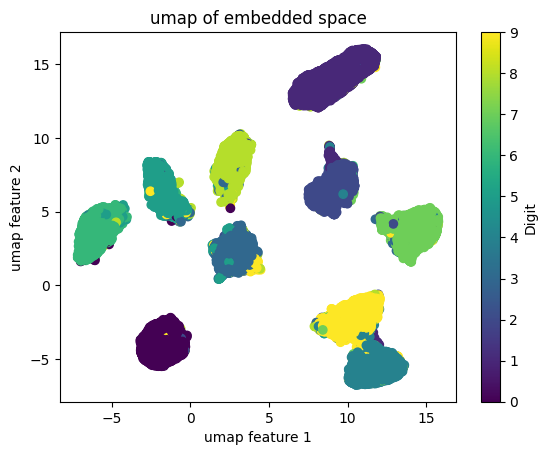

fitted umap
fitting pca


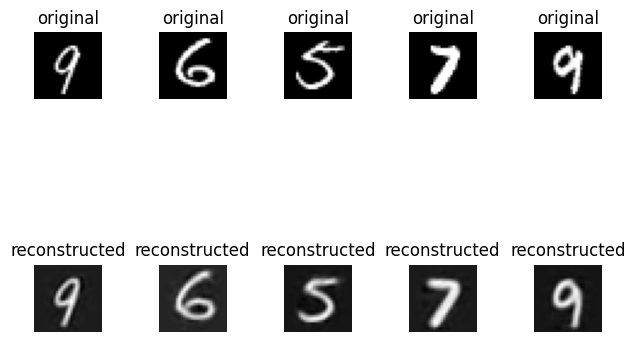

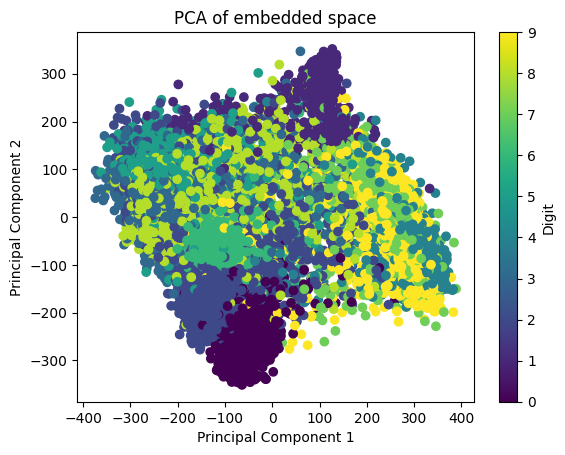

fitted pca
fitting umap


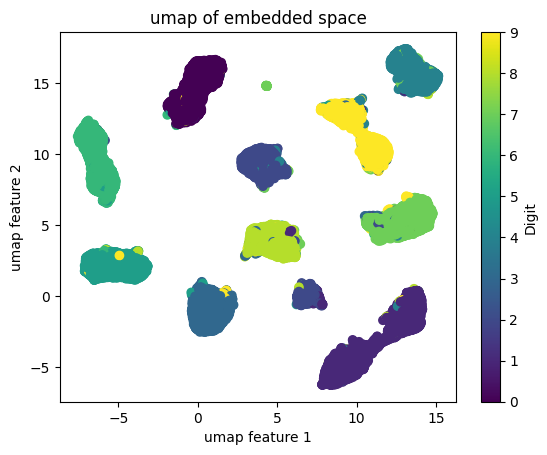

fitted umap


In [71]:
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/pretrained_AE.pth"))
autoencoder.fitted = True
visualize_peformance_AE(autoencoder, dataset, labels, (28,28), 5)

visualize_peformance_AE(dipect_test.autoencoder, dataset, labels, (28,28), 5)

In [ ]:
dataset, labels = load_mnist(return_X_y=True)
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/pretrained_AE.pth"))
autoencoder.fitted = True

dipect_test = DipECT(autoencoder=autoencoder, consider_num_assignments_for_growing=True, grow_interval=2, max_epochs=40)
dipect_test = dipect_test.fit_predict(dataset)

cpu


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  40466
#assignments:  29534


Epoch 2/40:   0%|          | 0/274 [00:06<?, ?batch/s]

#assignments best node:  40466


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  21841
#assignments:  19052
#assignments:  29107


Epoch 4/40:   0%|          | 0/274 [00:07<?, ?batch/s]

#assignments best node:  29107


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  21842
#assignments:  19033
#assignments:  20804
#assignments:  8321


Epoch 6/40:   0%|          | 1/274 [00:05<27:13,  5.98s/batch]

#assignments best node:  19033


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  21849
#assignments:  14001
#assignments:  5020
#assignments:  20838


Epoch 8/40:   0%|          | 0/274 [00:04<?, ?batch/s]

#assignments:  8292
#assignments best node:  21849


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8236
#assignments:  13644
#assignments:  13938
#assignments:  5064
#assignments:  20949
#assignments:  8169


Epoch 10/40:   0%|          | 0/274 [00:10<?, ?batch/s]

#assignments best node:  13644


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8553
#assignments:  7058
#assignments:  6515
#assignments:  13857
#assignments:  4956
#assignments:  20939
#assignments:  8122


Epoch 12/40:   0%|          | 0/274 [00:08<?, ?batch/s]

#assignments best node:  13857


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8564
#assignments:  7051
#assignments:  6499
#assignments:  6695
#assignments:  7123
#assignments:  5005
#assignments:  20883
#assignments:  8180


Epoch 14/40:   0%|          | 0/274 [00:11<?, ?batch/s]

#assignments best node:  20883


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8518
#assignments:  7049
#assignments:  6424
#assignments:  6767
#assignments:  7070
#assignments:  5130
#assignments:  12152
#assignments:  8742
#assignments:  8148


Epoch 16/40:   0%|          | 0/274 [00:13<?, ?batch/s]

#assignments best node:  12152


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8599
#assignments:  7053
#assignments:  6449
#assignments:  6699
#assignments:  7077
#assignments:  5064
#assignments:  6822
#assignments:  5029
#assignments:  9088
#assignments:  8120


Epoch 18/40:   0%|          | 0/274 [00:12<?, ?batch/s]

#assignments best node:  8599


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  2012
#assignments:  6672
#assignments:  7053
#assignments:  6440
#assignments:  6715
#assignments:  7044
#assignments:  5025
#assignments:  6823
#assignments:  4945
#assignments:  9185
#assignments:  8086


Epoch 20/40:   0%|          | 0/274 [00:15<?, ?batch/s]

#assignments best node:  9185


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  1985
#assignments:  6696
#assignments:  7030
#assignments:  6404
#assignments:  6737
#assignments:  7027
#assignments:  5039
#assignments:  6777
#assignments:  5031
#assignments:  4747
#assignments:  4401
#assignments:  8126


Epoch 22/40:   0%|          | 0/274 [00:17<?, ?batch/s]

#assignments best node:  8126


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  1985
#assignments:  6664
#assignments:  7044
#assignments:  6395
#assignments:  6739
#assignments:  7035
#assignments:  5083
#assignments:  6741
#assignments:  4929
#assignments:  4462
#assignments:  4776
#assignments:  3837
#assignments:  4310


Epoch 24/40:   0%|          | 0/274 [00:16<?, ?batch/s]

#assignments best node:  6739


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  1962
#assignments:  6694
#assignments:  7005
#assignments:  6453
#assignments:  3375
#assignments:  3315
#assignments:  7007
#assignments:  5131
#assignments:  6727
#assignments:  4984
#assignments:  4512
#assignments:  4712
#assignments:  3928
#assignments:  4195


Epoch 26/40:   0%|          | 0/274 [00:20<?, ?batch/s]

#assignments best node:  7007


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  1974
#assignments:  6734
#assignments:  6954
#assignments:  6433
#assignments:  3285
#assignments:  3390
#assignments:  3809
#assignments:  3208
#assignments:  5127
#assignments:  6722
#assignments:  5046
#assignments:  4545
#assignments:  4643
#assignments:  3818
#assignments:  4312


Epoch 28/40:   0%|          | 0/274 [00:20<?, ?batch/s]

#assignments best node:  6954


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  2040
#assignments:  6689
#assignments:  4680
#assignments:  2322
#assignments:  6455
#assignments:  3329
#assignments:  3383
#assignments:  3420
#assignments:  3594
#assignments:  5045
#assignments:  6715
#assignments:  4930
#assignments:  4516
#assignments:  4775
#assignments:  3855
#assignments:  4252


Epoch 30/40:   0%|          | 0/274 [00:19<?, ?batch/s]

#assignments best node:  6715


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  2014
#assignments:  6692
#assignments:  4217
#assignments:  2767
#assignments:  6441
#assignments:  3402
#assignments:  3344
#assignments:  3489
#assignments:  3511
#assignments:  5109
#assignments:  3657
#assignments:  3061
#assignments:  4977
#assignments:  4548
#assignments:  4693
#assignments:  3891
#assignments:  4187


Epoch 32/40:   0%|          | 0/274 [00:18<?, ?batch/s]

#assignments best node:  6441


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  2044
#assignments:  6765
#assignments:  3323
#assignments:  3649
#assignments:  3522
#assignments:  2883
#assignments:  3418
#assignments:  3306
#assignments:  3441
#assignments:  3571
#assignments:  5074
#assignments:  3401
#assignments:  3272
#assignments:  5061
#assignments:  4593
#assignments:  4595
#assignments:  3874
#assignments:  4208


Epoch 34/40:   0%|          | 0/274 [00:21<?, ?batch/s]

#assignments best node:  6765


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  1977
#assignments:  2729
#assignments:  3989
#assignments:  2673
#assignments:  4332
#assignments:  3400
#assignments:  2990
#assignments:  3480
#assignments:  3261
#assignments:  3478
#assignments:  3528
#assignments:  5123
#assignments:  3353
#assignments:  3327
#assignments:  5059
#assignments:  4613
#assignments:  4609
#assignments:  3883
#assignments:  4196


Epoch 36/40:   0%|          | 0/274 [00:26<?, ?batch/s]

#assignments best node:  4609


Predict: 100%|██████████| 274/274 [00:04<00:00, 58.27it/s]


In [ ]:
print(dipect_test.tree_.flat_accuracy(labels, 10))
print(dipect_test.tree_.flat_nmi(labels, 10))

0.9125428571428571
0.8586277490497786


In [53]:
# with different unimodal weight
dataset, labels = load_mnist(return_X_y=True)
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/MNIST_pretrained_autoencoder.pth"))
autoencoder.fitted = True

dipect_test = DipECT(autoencoder=autoencoder, consider_num_assignments_for_growing=True, grow_interval=2, max_epochs=40, unimodal_treshhold=1.0)
dipect_test = dipect_test.fit_predict(dataset/255)

cpu


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  31201
#assignments:  38799


Epoch 2/40:   0%|          | 0/274 [00:06<?, ?batch/s]

#assignments best node:  31201


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  9217
#assignments:  21377
#assignments:  39406


Epoch 4/40:   0%|          | 0/274 [00:07<?, ?batch/s]

#assignments best node:  39406


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  9042
#assignments:  21199
#assignments:  19449
#assignments:  20310


Epoch 6/40:   0%|          | 0/274 [00:12<?, ?batch/s]

#assignments best node:  19449


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8823
#assignments:  21123
#assignments:  13914
#assignments:  5498
#assignments:  20642


Epoch 8/40:   0%|          | 0/274 [00:08<?, ?batch/s]

#assignments best node:  13914


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8693
#assignments:  21104
#assignments:  7088
#assignments:  6780
#assignments:  5666
#assignments:  20669


Epoch 10/40:   0%|          | 0/274 [00:10<?, ?batch/s]

#assignments best node:  20669


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8761
#assignments:  21030
#assignments:  7042
#assignments:  6805
#assignments:  5595
#assignments:  12865
#assignments:  7902


Epoch 12/40:   0%|          | 0/274 [00:12<?, ?batch/s]

#assignments best node:  12865


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8731
#assignments:  21033
#assignments:  7016
#assignments:  6744
#assignments:  5639
#assignments:  7120
#assignments:  5702
#assignments:  8015


Epoch 14/40:   0%|          | 0/274 [00:13<?, ?batch/s]

#assignments best node:  8015


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8608
#assignments:  20985
#assignments:  7027
#assignments:  6756
#assignments:  5599
#assignments:  7159
#assignments:  5677
#assignments:  6643
#assignments:  1546


Epoch 16/40:   0%|          | 0/274 [00:12<?, ?batch/s]

#assignments best node:  20985


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8580
#assignments:  13882
#assignments:  7094
#assignments:  7003
#assignments:  6791
#assignments:  5604
#assignments:  7001
#assignments:  5762
#assignments:  6748
#assignments:  1535


Epoch 18/40:   0%|          | 0/274 [00:12<?, ?batch/s]

#assignments best node:  8580


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4373
#assignments:  4244
#assignments:  13745
#assignments:  7246
#assignments:  7008
#assignments:  6768
#assignments:  5676
#assignments:  7039
#assignments:  5722
#assignments:  6690
#assignments:  1489


Epoch 20/40:   0%|          | 0/274 [00:13<?, ?batch/s]

#assignments best node:  4244


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4369
#assignments:  3786
#assignments:  472
#assignments:  13681
#assignments:  7293
#assignments:  7002
#assignments:  6742
#assignments:  5700
#assignments:  7022
#assignments:  5792
#assignments:  6669
#assignments:  1472
#assignments best node:  7002


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4391
#assignments:  3736
#assignments:  428
#assignments:  13638
#assignments:  7315
#assignments:  3585
#assignments:  3391
#assignments:  6768
#assignments:  5656
#assignments:  7089
#assignments:  5785
#assignments:  6729
#assignments:  1489


Epoch 24/40:   0%|          | 0/274 [00:16<?, ?batch/s]

#assignments best node:  428


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4407
#assignments:  1999
#assignments:  1117
#assignments:  984
#assignments:  13574
#assignments:  7330
#assignments:  3446
#assignments:  3547
#assignments:  6762
#assignments:  5661
#assignments:  7074
#assignments:  5913
#assignments:  6701
#assignments:  1485


Epoch 26/40:   0%|          | 0/274 [00:17<?, ?batch/s]

#assignments best node:  984


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4469
#assignments:  2061
#assignments:  1720
#assignments:  78
#assignments:  207
#assignments:  13553
#assignments:  7314
#assignments:  3539
#assignments:  3452
#assignments:  6760
#assignments:  5683
#assignments:  7044
#assignments:  5895
#assignments:  6746
#assignments:  1479


Epoch 28/40:   0%|          | 0/274 [00:17<?, ?batch/s]

#assignments best node:  78


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4426
#assignments:  2021
#assignments:  1555
#assignments:  161
#assignments:  291
#assignments:  200
#assignments:  13559
#assignments:  7305
#assignments:  3384
#assignments:  3609
#assignments:  6761
#assignments:  5626
#assignments:  7056
#assignments:  5814
#assignments:  6727
#assignments:  1505


Epoch 30/40:   0%|          | 0/274 [00:17<?, ?batch/s]

#assignments best node:  1555


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4349
#assignments:  1835
#assignments:  280
#assignments:  462
#assignments:  391
#assignments:  962
#assignments:  307
#assignments:  13563
#assignments:  7321
#assignments:  3470
#assignments:  3534
#assignments:  6742
#assignments:  5645
#assignments:  7082
#assignments:  5901
#assignments:  6695
#assignments:  1461


Epoch 32/40:   0%|          | 0/274 [00:28<?, ?batch/s]

#assignments best node:  280


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4437
#assignments:  2047
#assignments:  155
#assignments:  86
#assignments:  581
#assignments:  399
#assignments:  579
#assignments:  317
#assignments:  13596
#assignments:  7253
#assignments:  3370
#assignments:  3600
#assignments:  6756
#assignments:  5656
#assignments:  7087
#assignments:  5874
#assignments:  6738
#assignments:  1469


Epoch 34/40:   0%|          | 0/274 [00:20<?, ?batch/s]

#assignments best node:  399


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4453
#assignments:  1886
#assignments:  255
#assignments:  107
#assignments:  581
#assignments:  154
#assignments:  515
#assignments:  384
#assignments:  295
#assignments:  13527
#assignments:  7263
#assignments:  3341
#assignments:  3641
#assignments:  6764
#assignments:  5637
#assignments:  7041
#assignments:  5940
#assignments:  6731
#assignments:  1485


Epoch 36/40:   0%|          | 0/274 [00:21<?, ?batch/s]

#assignments best node:  154


Predict: 100%|██████████| 274/274 [00:08<00:00, 33.35it/s]


In [66]:
dataset, labels = load_mnist(return_X_y=True)
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/MNIST_pretrained_autoencoder.pth"))
autoencoder.fitted = True

dipect_test = DipECT(autoencoder=autoencoder, use_pvalue=False, grow_interval=4, max_epochs=50, unimodal_treshhold=1.0)
dipect_test = dipect_test.fit_predict(dataset/255)

cpu


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  30633
#assignments:  39367


Epoch 4/50:   0%|          | 0/274 [00:08<?, ?batch/s]

#assignments best node:  39367


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  30101
#assignments:  19395
#assignments:  20504


Epoch 8/50:   0%|          | 0/274 [00:06<?, ?batch/s]

#assignments best node:  30101


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8723
#assignments:  21173
#assignments:  19220
#assignments:  20884


Epoch 12/50:   0%|          | 0/274 [00:08<?, ?batch/s]

#assignments best node:  19220


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8561
#assignments:  21238
#assignments:  13919
#assignments:  5321
#assignments:  20961


Epoch 16/50:   0%|          | 0/274 [00:11<?, ?batch/s]

#assignments best node:  13919


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8560
#assignments:  21134
#assignments:  7037
#assignments:  6828
#assignments:  5425
#assignments:  21016


Epoch 20/50:   0%|          | 0/274 [00:09<?, ?batch/s]

#assignments best node:  21016


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8467
#assignments:  21054
#assignments:  7066
#assignments:  6770
#assignments:  5459
#assignments:  8343
#assignments:  12841


Epoch 24/50:   0%|          | 0/274 [00:12<?, ?batch/s]

#assignments best node:  12841


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8421
#assignments:  20988
#assignments:  7026
#assignments:  6786
#assignments:  5404
#assignments:  8427
#assignments:  5778
#assignments:  7170


Epoch 28/50:   0%|          | 0/274 [00:11<?, ?batch/s]

#assignments best node:  20988


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8417
#assignments:  13757
#assignments:  7279
#assignments:  6993
#assignments:  6794
#assignments:  5425
#assignments:  8476
#assignments:  5764
#assignments:  7095


Epoch 32/50:   0%|          | 0/274 [00:13<?, ?batch/s]

#assignments best node:  8476


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8439
#assignments:  13681
#assignments:  7311
#assignments:  7021
#assignments:  6785
#assignments:  5330
#assignments:  1838
#assignments:  6707
#assignments:  5785
#assignments:  7103


Epoch 36/50:   0%|          | 0/274 [00:14<?, ?batch/s]

#assignments best node:  13681


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8395
#assignments:  6711
#assignments:  6936
#assignments:  7349
#assignments:  6995
#assignments:  6762
#assignments:  5409
#assignments:  1808
#assignments:  6746
#assignments:  5828
#assignments:  7061


Epoch 40/50:   0%|          | 0/274 [00:13<?, ?batch/s]

#assignments best node:  6711


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8342
#assignments:  3643
#assignments:  3267
#assignments:  6697
#assignments:  7424
#assignments:  7009
#assignments:  6771
#assignments:  5366
#assignments:  1821
#assignments:  6758
#assignments:  5834
#assignments:  7068


Epoch 44/50:   0%|          | 0/274 [00:12<?, ?batch/s]

#assignments best node:  6697


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8430
#assignments:  3689
#assignments:  3286
#assignments:  3414
#assignments:  3203
#assignments:  7363
#assignments:  6974
#assignments:  6756
#assignments:  5394
#assignments:  1816
#assignments:  6789
#assignments:  5854
#assignments:  7032


Epoch 48/50:   0%|          | 0/274 [00:20<?, ?batch/s]

#assignments best node:  7363


Predict: 100%|██████████| 274/274 [00:04<00:00, 55.15it/s]


In [72]:
print(dipect_test.tree_.flat_accuracy(labels, 10))
print(dipect_test.tree_.flat_nmi(labels, 10))

0.8318571428571429
0.8471026705153308


In [69]:
dataset, labels = load_mnist(return_X_y=True)
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/MNIST_pretrained_autoencoder.pth"))
autoencoder.fitted = True

dipect_test_1 = DipECT(autoencoder=autoencoder, use_pvalue=True, grow_interval=2, max_epochs=40, unimodal_treshhold=1.0)
dipect_test_1 = dipect_test_1.fit_predict(dataset/255)

cpu


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  31201
#assignments:  38799


Epoch 2/40:   0%|          | 0/274 [00:09<?, ?batch/s]

#assignments best node:  31201


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  9293
#assignments:  21440
#assignments:  39267


Epoch 4/40:   0%|          | 0/274 [00:07<?, ?batch/s]

#assignments best node:  39267


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8939
#assignments:  21230
#assignments:  19335
#assignments:  20496


Epoch 6/40:   0%|          | 0/274 [00:08<?, ?batch/s]

#assignments best node:  19335


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8731
#assignments:  21172
#assignments:  5428
#assignments:  13917
#assignments:  20752


Epoch 8/40:   0%|          | 0/274 [00:08<?, ?batch/s]

#assignments best node:  13917


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8765
#assignments:  21076
#assignments:  5474
#assignments:  6753
#assignments:  7086
#assignments:  20846


Epoch 10/40:   0%|          | 0/274 [00:09<?, ?batch/s]

#assignments best node:  20846


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8602
#assignments:  21092
#assignments:  5434
#assignments:  6728
#assignments:  7050
#assignments:  8125
#assignments:  12969


Epoch 12/40:   0%|          | 0/274 [00:10<?, ?batch/s]

#assignments best node:  8125


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8553
#assignments:  21099
#assignments:  5421
#assignments:  6792
#assignments:  7043
#assignments:  1728
#assignments:  6613
#assignments:  12751


Epoch 14/40:   0%|          | 0/274 [00:10<?, ?batch/s]

#assignments best node:  12751


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8462
#assignments:  21007
#assignments:  5579
#assignments:  6782
#assignments:  7030
#assignments:  1703
#assignments:  6609
#assignments:  5763
#assignments:  7065


Epoch 16/40:   0%|          | 0/274 [00:12<?, ?batch/s]

#assignments best node:  21007


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8485
#assignments:  13909
#assignments:  7104
#assignments:  5486
#assignments:  6771
#assignments:  7019
#assignments:  1772
#assignments:  6595
#assignments:  5810
#assignments:  7049


Epoch 18/40:   0%|          | 0/274 [00:18<?, ?batch/s]

#assignments best node:  6771


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8486
#assignments:  13836
#assignments:  7183
#assignments:  5558
#assignments:  3380
#assignments:  3410
#assignments:  7007
#assignments:  1686
#assignments:  6631
#assignments:  5800
#assignments:  7023


Epoch 20/40:   0%|          | 0/274 [00:19<?, ?batch/s]

#assignments best node:  8486


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4171
#assignments:  4325
#assignments:  13737
#assignments:  7205
#assignments:  5611
#assignments:  3389
#assignments:  3339
#assignments:  7021
#assignments:  1625
#assignments:  6686
#assignments:  5878
#assignments:  7013


Epoch 22/40:   0%|          | 0/274 [00:16<?, ?batch/s]

#assignments best node:  4171


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  3945
#assignments:  355
#assignments:  4189
#assignments:  13690
#assignments:  7242
#assignments:  5505
#assignments:  3395
#assignments:  3339
#assignments:  7013
#assignments:  1672
#assignments:  6707
#assignments:  5903
#assignments:  7045


Epoch 24/40:   0%|          | 0/274 [00:15<?, ?batch/s]

#assignments best node:  355


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  2039
#assignments:  1410
#assignments:  719
#assignments:  4327
#assignments:  13626
#assignments:  7244
#assignments:  5581
#assignments:  3402
#assignments:  3366
#assignments:  6993
#assignments:  1658
#assignments:  6720
#assignments:  5854
#assignments:  7061


Epoch 26/40:   0%|          | 0/274 [00:16<?, ?batch/s]

#assignments best node:  719


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  1943
#assignments:  1196
#assignments:  199
#assignments:  850
#assignments:  4382
#assignments:  13635
#assignments:  7324
#assignments:  5516
#assignments:  3444
#assignments:  3319
#assignments:  6999
#assignments:  1733
#assignments:  6707
#assignments:  5766
#assignments:  6987


Epoch 28/40:   0%|          | 0/274 [00:16<?, ?batch/s]

#assignments best node:  1196


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  1850
#assignments:  200
#assignments:  1028
#assignments:  169
#assignments:  947
#assignments:  4328
#assignments:  13638
#assignments:  7292
#assignments:  5520
#assignments:  3298
#assignments:  3459
#assignments:  7005
#assignments:  1721
#assignments:  6696
#assignments:  5802
#assignments:  7047


Epoch 30/40:   0%|          | 0/274 [00:20<?, ?batch/s]

#assignments best node:  200


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  2234
#assignments:  229
#assignments:  344
#assignments:  574
#assignments:  167
#assignments:  739
#assignments:  4216
#assignments:  13596
#assignments:  7268
#assignments:  5527
#assignments:  3396
#assignments:  3411
#assignments:  6992
#assignments:  1719
#assignments:  6729
#assignments:  5866
#assignments:  6993


Epoch 32/40:   0%|          | 0/274 [00:13<?, ?batch/s]

#assignments best node:  229


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  1806
#assignments:  69
#assignments:  161
#assignments:  234
#assignments:  619
#assignments:  235
#assignments:  1148
#assignments:  4167
#assignments:  13581
#assignments:  7342
#assignments:  5539
#assignments:  3342
#assignments:  3416
#assignments:  7007
#assignments:  1690
#assignments:  6648
#assignments:  5979
#assignments:  7017


Epoch 34/40:   0%|          | 0/274 [00:22<?, ?batch/s]

#assignments best node:  235


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  1751
#assignments:  12
#assignments:  53
#assignments:  630
#assignments:  601
#assignments:  54
#assignments:  157
#assignments:  909
#assignments:  4359
#assignments:  13585
#assignments:  7274
#assignments:  5446
#assignments:  3270
#assignments:  3466
#assignments:  6972
#assignments:  1774
#assignments:  6757
#assignments:  5890
#assignments:  7040


Epoch 36/40:   0%|          | 0/274 [00:17<?, ?batch/s]

#assignments best node:  54


Predict: 100%|██████████| 274/274 [00:05<00:00, 47.86it/s]


In [73]:
print(dipect_test_1.tree_.flat_accuracy(labels, 10))
print(dipect_test_1.tree_.flat_nmi(labels, 10))

0.8321571428571428
0.843983787866966


In [68]:
dataset, labels = load_mnist(return_X_y=True)
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/MNIST_pretrained_autoencoder.pth"))
autoencoder.fitted = True

dipect_test_2 = DipECT(autoencoder=autoencoder, use_pvalue=True, grow_interval=2, max_epochs=40, unimodal_treshhold=0.95)
dipect_test_2 = dipect_test_2.fit_predict(dataset/255)

cpu


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  31919
#assignments:  38081


Epoch 2/40:   0%|          | 0/274 [00:05<?, ?batch/s]

#assignments best node:  31919


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  21368
#assignments:  9465
#assignments:  39167


Epoch 4/40:   0%|          | 0/274 [00:06<?, ?batch/s]

#assignments best node:  39167


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  21275
#assignments:  9119
#assignments:  19393
#assignments:  20213


Epoch 6/40:   0%|          | 0/274 [00:07<?, ?batch/s]

#assignments best node:  19393


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  21172
#assignments:  9063
#assignments:  5393
#assignments:  13894
#assignments:  20478


Epoch 8/40:   0%|          | 0/274 [00:11<?, ?batch/s]

#assignments best node:  13894


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  21106
#assignments:  8884
#assignments:  5392
#assignments:  6734
#assignments:  7080
#assignments:  20804


Epoch 10/40:   0%|          | 0/274 [00:08<?, ?batch/s]

#assignments best node:  20804


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  21054
#assignments:  8789
#assignments:  5376
#assignments:  6790
#assignments:  7049
#assignments:  8182
#assignments:  12760


Epoch 12/40:   0%|          | 0/274 [00:09<?, ?batch/s]

#assignments best node:  8182


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  20987
#assignments:  8784
#assignments:  5408
#assignments:  6767
#assignments:  7058
#assignments:  6627
#assignments:  1724
#assignments:  12645


Epoch 14/40:   0%|          | 0/274 [00:11<?, ?batch/s]

#assignments best node:  20987


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  13996
#assignments:  7066
#assignments:  8722
#assignments:  5415
#assignments:  6752
#assignments:  7029
#assignments:  6585
#assignments:  1766
#assignments:  12669


Epoch 16/40:   0%|          | 0/274 [00:13<?, ?batch/s]

#assignments best node:  12669


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  13828
#assignments:  7239
#assignments:  8869
#assignments:  5395
#assignments:  6776
#assignments:  7000
#assignments:  6662
#assignments:  1752
#assignments:  7011
#assignments:  5468


Epoch 18/40:   0%|          | 0/274 [00:14<?, ?batch/s]

#assignments best node:  7239


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  13723
#assignments:  3928
#assignments:  3376
#assignments:  8734
#assignments:  5407
#assignments:  6765
#assignments:  7010
#assignments:  6695
#assignments:  1749
#assignments:  7046
#assignments:  5567


Epoch 20/40:   0%|          | 0/274 [00:15<?, ?batch/s]

#assignments best node:  6695


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  13645
#assignments:  4099
#assignments:  3283
#assignments:  8657
#assignments:  5384
#assignments:  6727
#assignments:  7024
#assignments:  3105
#assignments:  3585
#assignments:  1770
#assignments:  7037
#assignments:  5684


  0%|          | 0/274 [00:14<?, ?batch/s]


Stopped algorithm earlier since unimodality treshhold is reached


Predict: 100%|██████████| 274/274 [00:05<00:00, 50.33it/s]


In [74]:
print(dipect_test_2.tree_.flat_accuracy(labels, 10))
print(dipect_test_2.tree_.flat_nmi(labels, 10))

0.8245285714285714
0.8324636472104381


In [67]:
dataset, labels = load_mnist(return_X_y=True)
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/MNIST_pretrained_autoencoder.pth"))
autoencoder.fitted = True

dipect_test_3 = DipECT(autoencoder=autoencoder, use_pvalue=False, grow_interval=2, max_epochs=40, unimodal_treshhold=0.95)
dipect_test_3 = dipect_test_3.fit_predict(dataset/255)

cpu


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  31201
#assignments:  38799


Epoch 2/40:   0%|          | 0/274 [00:06<?, ?batch/s]

#assignments best node:  38799


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  30651
#assignments:  19339
#assignments:  20010


Epoch 4/40:   0%|          | 0/274 [00:05<?, ?batch/s]

#assignments best node:  30651


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8912
#assignments:  21219
#assignments:  19358
#assignments:  20511


Epoch 6/40:   0%|          | 0/274 [00:07<?, ?batch/s]

#assignments best node:  19358


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8730
#assignments:  21186
#assignments:  5292
#assignments:  13963
#assignments:  20829


Epoch 8/40:   0%|          | 0/274 [00:08<?, ?batch/s]

#assignments best node:  13963


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8654
#assignments:  21125
#assignments:  5441
#assignments:  6753
#assignments:  7096
#assignments:  20931


Epoch 10/40:   0%|          | 0/274 [00:09<?, ?batch/s]

#assignments best node:  20931


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8470
#assignments:  21081
#assignments:  5392
#assignments:  6775
#assignments:  7079
#assignments:  8211


Epoch 12/40:   0%|          | 0/274 [00:08<?, ?batch/s]

#assignments:  12992
#assignments best node:  12992


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8480
#assignments:  21081
#assignments:  5341
#assignments:  6803
#assignments:  7051
#assignments:  8318
#assignments:  7134
#assignments:  5792


Epoch 14/40:   0%|          | 0/274 [00:12<?, ?batch/s]

#assignments best node:  21081


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8413
#assignments:  9068
#assignments:  11930
#assignments:  5406
#assignments:  6767
#assignments:  7047
#assignments:  8429
#assignments:  7138
#assignments:  5802


Epoch 16/40:   0%|          | 0/274 [00:10<?, ?batch/s]

#assignments best node:  8429


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8431
#assignments:  9485
#assignments:  11601
#assignments:  5377
#assignments:  6805
#assignments:  7010
#assignments:  6608
#assignments:  1783
#assignments:  7086


Epoch 18/40:   0%|          | 0/274 [00:11<?, ?batch/s]

#assignments:  5814
#assignments best node:  8431


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4266
#assignments:  4190
#assignments:  9358
#assignments:  11655
#assignments:  5422
#assignments:  6792
#assignments:  7018
#assignments:  6660
#assignments:  1750
#assignments:  7047
#assignments:  5842


Epoch 20/40:   0%|          | 0/274 [00:18<?, ?batch/s]

#assignments best node:  6792


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4280
#assignments:  4174
#assignments:  9290
#assignments:  11676
#assignments:  5348
#assignments:  3033
#assignments:  3736
#assignments:  7015
#assignments:  6653
#assignments:  1837
#assignments:  7059
#assignments:  5899


Epoch 22/40:   0%|          | 0/274 [00:13<?, ?batch/s]

#assignments best node:  5348


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4242
#assignments:  4116
#assignments:  9179
#assignments:  11774
#assignments:  3066
#assignments:  2276
#assignments:  3272
#assignments:  3525
#assignments:  7017
#assignments:  6725
#assignments:  1849
#assignments:  7050
#assignments:  5909


Epoch 24/40:   0%|          | 0/274 [00:15<?, ?batch/s]

#assignments best node:  9179


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4294
#assignments:  4076
#assignments:  4724
#assignments:  4496
#assignments:  11684
#assignments:  2595
#assignments:  2776
#assignments:  3278
#assignments:  3496
#assignments:  7008
#assignments:  6720
#assignments:  1841
#assignments:  7049
#assignments:  5963


Epoch 26/40:   0%|          | 0/274 [00:19<?, ?batch/s]

#assignments best node:  4496


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4307
#assignments:  4040
#assignments:  4507
#assignments:  2101
#assignments:  2723
#assignments:  11647
#assignments:  3478
#assignments:  1944
#assignments:  3356
#assignments:  3414
#assignments:  7005
#assignments:  6645
#assignments:  1760
#assignments:  7078
#assignments:  5995


Epoch 28/40:   0%|          | 0/274 [00:22<?, ?batch/s]

#assignments best node:  2101


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4306
#assignments:  4076
#assignments:  4504
#assignments:  511
#assignments:  1414
#assignments:  2759
#assignments:  11718
#assignments:  3373
#assignments:  1985
#assignments:  3374
#assignments:  3417
#assignments:  6977
#assignments:  6660
#assignments:  1865
#assignments:  7063
#assignments:  5998


Epoch 30/40:   0%|          | 0/274 [00:17<?, ?batch/s]

#assignments best node:  11718


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4276
#assignments:  4053
#assignments:  4511
#assignments:  1318
#assignments:  749
#assignments:  2812
#assignments:  8898
#assignments:  2684
#assignments:  3365
#assignments:  1987
#assignments:  3345
#assignments:  3402
#assignments:  6955
#assignments:  6778
#assignments:  1846
#assignments:  7039
#assignments:  5982


Epoch 32/40:   0%|          | 0/274 [00:25<?, ?batch/s]

#assignments best node:  8898


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4285
#assignments:  3983
#assignments:  4519
#assignments:  989
#assignments:  955
#assignments:  2740
#assignments:  5250
#assignments:  3878
#assignments:  2686
#assignments:  2979
#assignments:  2432
#assignments:  3371
#assignments:  3399
#assignments:  6964
#assignments:  6699
#assignments:  1787
#assignments:  7071
#assignments:  6013


Epoch 34/40:   0%|          | 0/274 [00:22<?, ?batch/s]

#assignments best node:  3983


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4278
#assignments:  2159
#assignments:  1843
#assignments:  4526
#assignments:  1010
#assignments:  1043
#assignments:  2717
#assignments:  5140
#assignments:  3372
#assignments:  3169
#assignments:  2500
#assignments:  2809
#assignments:  3402
#assignments:  3388
#assignments:  6963
#assignments:  6754
#assignments:  1860
#assignments:  7056
#assignments:  6011


Epoch 36/40:   0%|          | 0/274 [00:28<?, ?batch/s]

#assignments best node:  4526


Predict: 100%|██████████| 274/274 [00:05<00:00, 51.76it/s]


In [75]:
print(dipect_test_3.tree_.flat_accuracy(labels, 10))
print(dipect_test_3.tree_.flat_nmi(labels, 10))

0.8330285714285715
0.8290861597904301


In [70]:
# ohne luni loss
dataset, labels = load_mnist(return_X_y=True)
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/MNIST_pretrained_autoencoder.pth"))
autoencoder.fitted = True

dipect_test_4 = DipECT(autoencoder=autoencoder, use_pvalue=False, grow_interval=2, max_epochs=40, unimodal_treshhold=1.0, unimodal_loss_increase_method="noUnimodalLoss")
dipect_test_4 = dipect_test_4.fit_predict(dataset/255)

cpu


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  31919
#assignments:  38081


Epoch 2/40:   0%|          | 0/274 [00:11<?, ?batch/s]

#assignments best node:  38081


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  30536
#assignments:  19942
#assignments:  19522
#assignments best node:  30536


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  21533
#assignments:  8898
#assignments:  20091
#assignments:  19478


Epoch 6/40:   0%|          | 0/274 [00:06<?, ?batch/s]

#assignments best node:  19478


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  21381
#assignments:  8645
#assignments:  20593
#assignments:  5464
#assignments:  13917


Epoch 8/40:   0%|          | 0/274 [00:09<?, ?batch/s]

#assignments best node:  13917


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  21227
#assignments:  8615
#assignments:  20730
#assignments:  5540
#assignments:  6819
#assignments:  7069


Epoch 10/40:   0%|          | 0/274 [00:08<?, ?batch/s]

#assignments best node:  20730


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  21173
#assignments:  8556
#assignments:  12996
#assignments:  7947
#assignments:  5463
#assignments:  6816
#assignments:  7049


Epoch 12/40:   0%|          | 0/274 [00:08<?, ?batch/s]

#assignments best node:  12996


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  21187
#assignments:  8642
#assignments:  7096
#assignments:  5714
#assignments:  8074
#assignments:  5470
#assignments:  6777
#assignments:  7040


Epoch 14/40:   0%|          | 0/274 [00:08<?, ?batch/s]

#assignments best node:  21187


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  7265
#assignments:  13824
#assignments:  8561
#assignments:  7093
#assignments:  5780
#assignments:  8155
#assignments:  5513
#assignments:  6770
#assignments:  7039


Epoch 16/40:   0%|          | 0/274 [00:11<?, ?batch/s]

#assignments best node:  8155


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  7325
#assignments:  13702
#assignments:  8544
#assignments:  7074
#assignments:  5778
#assignments:  1773
#assignments:  6561
#assignments:  5418
#assignments:  6782
#assignments:  7043


Epoch 18/40:   0%|          | 0/274 [00:11<?, ?batch/s]

#assignments best node:  13702


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  7391
#assignments:  6723
#assignments:  6999
#assignments:  8515
#assignments:  7104
#assignments:  5764
#assignments:  1781
#assignments:  6526
#assignments:  5405
#assignments:  6782
#assignments:  7010


Epoch 20/40:   0%|          | 0/274 [00:13<?, ?batch/s]

#assignments best node:  6999


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  7468
#assignments:  6734
#assignments:  3643
#assignments:  3252
#assignments:  8477
#assignments:  7094
#assignments:  5872
#assignments:  1765
#assignments:  6523
#assignments:  5419
#assignments:  6743
#assignments:  7010


Epoch 22/40:   0%|          | 0/274 [00:22<?, ?batch/s]

#assignments best node:  6734


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  7507
#assignments:  3120
#assignments:  3673
#assignments:  3557
#assignments:  3273
#assignments:  8449
#assignments:  7051
#assignments:  5868
#assignments:  1762
#assignments:  6542
#assignments:  5428
#assignments:  6758
#assignments:  7012


Epoch 24/40:   0%|          | 0/274 [00:17<?, ?batch/s]

#assignments best node:  7507


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  5334
#assignments:  2221
#assignments:  3180
#assignments:  3528
#assignments:  3644
#assignments:  3285
#assignments:  8450
#assignments:  7059
#assignments:  5827
#assignments:  1773
#assignments:  6550
#assignments:  5370
#assignments:  6774
#assignments:  7005


Epoch 26/40:   0%|          | 0/274 [00:21<?, ?batch/s]

#assignments best node:  8450


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  5147
#assignments:  2346
#assignments:  3139
#assignments:  3450
#assignments:  3734
#assignments:  3279
#assignments:  4260
#assignments:  4192
#assignments:  7060
#assignments:  5836
#assignments:  1810
#assignments:  6597
#assignments:  5362
#assignments:  6778
#assignments:  7010


Epoch 28/40:   0%|          | 0/274 [00:21<?, ?batch/s]

#assignments best node:  7010


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4953
#assignments:  2565
#assignments:  3136
#assignments:  3447
#assignments:  3739
#assignments:  3319
#assignments:  4278
#assignments:  4150
#assignments:  7075
#assignments:  5855
#assignments:  1844
#assignments:  6560
#assignments:  5319
#assignments:  6753
#assignments:  3421
#assignments:  3586


Epoch 30/40:   0%|          | 0/274 [00:20<?, ?batch/s]

#assignments best node:  6753


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4954
#assignments:  2556
#assignments:  3179
#assignments:  3512
#assignments:  3681
#assignments:  3260
#assignments:  4242
#assignments:  4203
#assignments:  7086
#assignments:  5808
#assignments:  1828
#assignments:  6563
#assignments:  5369
#assignments:  3308
#assignments:  3443
#assignments:  3339
#assignments:  3669


Epoch 32/40:   0%|          | 0/274 [00:24<?, ?batch/s]

#assignments best node:  6563


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4773
#assignments:  2691
#assignments:  3105
#assignments:  3312
#assignments:  3801
#assignments:  3379
#assignments:  4183
#assignments:  4221
#assignments:  7120
#assignments:  5868
#assignments:  1777
#assignments:  3117
#assignments:  3436
#assignments:  5434
#assignments:  3443
#assignments:  3340
#assignments:  3423
#assignments:  3577


Epoch 34/40:   0%|          | 0/274 [00:28<?, ?batch/s]

#assignments best node:  7120


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4725
#assignments:  2739
#assignments:  3129
#assignments:  3315
#assignments:  3781
#assignments:  3381
#assignments:  4181
#assignments:  4231
#assignments:  4305
#assignments:  2750
#assignments:  5913
#assignments:  1844
#assignments:  3109
#assignments:  3478
#assignments:  5327
#assignments:  3401
#assignments:  3385
#assignments:  3473
#assignments:  3533


Epoch 36/40:   0%|          | 0/274 [00:22<?, ?batch/s]

#assignments best node:  5913


Predict: 100%|██████████| 274/274 [00:09<00:00, 30.44it/s]


In [76]:
print(dipect_test_4.tree_.flat_accuracy(labels, 10))
print(dipect_test_4.tree_.flat_nmi(labels, 10))

0.8355285714285714
0.8495669167047698


In [71]:
dataset, labels = load_mnist(return_X_y=True)
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/MNIST_pretrained_autoencoder.pth"))
autoencoder.fitted = True

dipect_test_5 = DipECT(autoencoder=autoencoder, use_pvalue=False, grow_interval=2, max_epochs=40, unimodal_treshhold=1.0, unimodal_loss_increase_method="exponential")
dipect_test_5 = dipect_test_5.fit_predict(dataset/255)

cpu


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  31430
#assignments:  38570


Epoch 2/40:   0%|          | 0/274 [00:08<?, ?batch/s]

#assignments best node:  38570


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  30589
#assignments:  20016
#assignments:  19395


Epoch 4/40:   0%|          | 0/274 [00:09<?, ?batch/s]

#assignments best node:  30589


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  21430
#assignments:  8794
#assignments:  20624
#assignments:  19152


Epoch 6/40:   0%|          | 0/274 [00:14<?, ?batch/s]

#assignments best node:  19152


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  21203
#assignments:  8784
#assignments:  20818
#assignments:  5238
#assignments:  13957


Epoch 8/40:   0%|          | 0/274 [00:16<?, ?batch/s]

#assignments best node:  13957


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  21152
#assignments:  8650
#assignments:  21052
#assignments:  5305
#assignments:  6786
#assignments:  7055


Epoch 10/40:   0%|          | 0/274 [00:14<?, ?batch/s]

#assignments best node:  21052


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  21221
#assignments:  8518
#assignments:  12875
#assignments:  8260
#assignments:  5297
#assignments:  6795
#assignments:  7034


Epoch 12/40:   0%|          | 0/274 [00:26<?, ?batch/s]

#assignments best node:  12875


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  21110
#assignments:  8561
#assignments:  5699
#assignments:  7077
#assignments:  8349
#assignments:  5367
#assignments:  6808
#assignments:  7029


Epoch 14/40:   0%|          | 0/274 [00:15<?, ?batch/s]

#assignments best node:  21110


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  13995
#assignments:  7078
#assignments:  8555
#assignments:  5767
#assignments:  7108
#assignments:  8280
#assignments:  5430
#assignments:  6795
#assignments:  6992


Epoch 16/40:   0%|          | 0/274 [00:17<?, ?batch/s]

#assignments best node:  8280


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  13786
#assignments:  7252
#assignments:  8531
#assignments:  5796
#assignments:  7103
#assignments:  6583
#assignments:  1863
#assignments:  5294
#assignments:  6781
#assignments:  7011


Epoch 18/40:   0%|          | 0/274 [00:23<?, ?batch/s]

#assignments best node:  13786


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  6998
#assignments:  6751
#assignments:  7351
#assignments:  8479
#assignments:  5754
#assignments:  7094
#assignments:  6630
#assignments:  1779
#assignments:  5376
#assignments:  6794
#assignments:  6994


Epoch 20/40:   0%|          | 0/274 [00:20<?, ?batch/s]

#assignments best node:  6998


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  3997
#assignments:  3115
#assignments:  6574
#assignments:  7346
#assignments:  8458
#assignments:  5817
#assignments:  7055
#assignments:  6681
#assignments:  1795
#assignments:  5375
#assignments:  6768
#assignments:  7019


Epoch 22/40:   0%|          | 0/274 [00:23<?, ?batch/s]

#assignments best node:  6574


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  3806
#assignments:  3151
#assignments:  3446
#assignments:  3185
#assignments:  7470
#assignments:  8458
#assignments:  5767
#assignments:  7090
#assignments:  6652
#assignments:  1846
#assignments:  5318
#assignments:  6794
#assignments:  7017


Epoch 24/40:   0%|          | 0/274 [00:26<?, ?batch/s]

#assignments best node:  7470


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  3984
#assignments:  3278
#assignments:  3332
#assignments:  3016
#assignments:  2511
#assignments:  4917
#assignments:  8463
#assignments:  5846
#assignments:  7082
#assignments:  6648
#assignments:  1857
#assignments:  5286
#assignments:  6784
#assignments:  6996


Epoch 26/40:   0%|          | 0/274 [00:28<?, ?batch/s]

#assignments best node:  8463


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  3919
#assignments:  3275
#assignments:  3305
#assignments:  3067
#assignments:  2607
#assignments:  4903
#assignments:  4121
#assignments:  4392
#assignments:  5775
#assignments:  7067
#assignments:  6642
#assignments:  1868
#assignments:  5273
#assignments:  6766
#assignments:  7020


Epoch 28/40:   0%|          | 0/274 [00:29<?, ?batch/s]

#assignments best node:  4392


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  3987
#assignments:  3407
#assignments:  3165
#assignments:  3036
#assignments:  2786
#assignments:  4736
#assignments:  4102
#assignments:  440
#assignments:  3971
#assignments:  5785
#assignments:  7072
#assignments:  6624
#assignments:  1868
#assignments:  5260
#assignments:  6769
#assignments:  6992


Epoch 30/40:   0%|          | 0/274 [00:31<?, ?batch/s]

#assignments best node:  6769


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  3986
#assignments:  3358
#assignments:  3185
#assignments:  3068
#assignments:  2852
#assignments:  4663
#assignments:  4201
#assignments:  349
#assignments:  3925
#assignments:  5802
#assignments:  7059
#assignments:  6637
#assignments:  1851
#assignments:  5297
#assignments:  3218
#assignments:  3555
#assignments:  6994


Epoch 32/40:   0%|          | 0/274 [00:29<?, ?batch/s]

#assignments best node:  7059


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  3973
#assignments:  3356
#assignments:  3185
#assignments:  3040
#assignments:  2841
#assignments:  4666
#assignments:  4223
#assignments:  365
#assignments:  3934
#assignments:  5789
#assignments:  2895
#assignments:  4152
#assignments:  6693
#assignments:  1892
#assignments:  5243
#assignments:  3414
#assignments:  3340
#assignments:  6999


Epoch 34/40:   0%|          | 0/274 [00:23<?, ?batch/s]

#assignments best node:  365


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4071
#assignments:  3379
#assignments:  3171
#assignments:  2972
#assignments:  2916
#assignments:  4608
#assignments:  4216
#assignments:  1589
#assignments:  838
#assignments:  1893
#assignments:  5842
#assignments:  2650
#assignments:  4333
#assignments:  6658
#assignments:  1908
#assignments:  5211
#assignments:  3335
#assignments:  3438
#assignments:  6972


Epoch 36/40:   0%|          | 0/274 [00:21<?, ?batch/s]

#assignments best node:  1589


Predict: 100%|██████████| 274/274 [00:10<00:00, 25.69it/s]


In [77]:
print(dipect_test_5.tree_.flat_accuracy(labels, 10))
print(dipect_test_5.tree_.flat_nmi(labels, 10))

0.8300857142857143
0.8414029201849674


In [78]:
dataset, labels = load_mnist(return_X_y=True)
autoencoder = FeedforwardAutoencoder([dataset.shape[1], 500, 500, 2000, 10])
autoencoder.load_state_dict(torch.load("./practical/DeepClustering/DipECT/MNIST_pretrained_autoencoder.pth"))
autoencoder.fitted = True

dipect_test_5 = DipECT(autoencoder=autoencoder, use_pvalue=False, grow_interval=2, max_epochs=45, unimodal_treshhold=1.0)
dipect_test_5 = dipect_test_5.fit_predict(dataset/255)

cpu


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  31919
#assignments:  38081


Epoch 2/45:   0%|          | 0/274 [00:15<?, ?batch/s]

#assignments best node:  38081


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  30687
#assignments:  19892
#assignments:  19421


Epoch 4/45:   0%|          | 0/274 [00:09<?, ?batch/s]

#assignments best node:  30687


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  9035
#assignments:  21359
#assignments:  20258
#assignments:  19348


Epoch 6/45:   0%|          | 0/274 [00:18<?, ?batch/s]

#assignments best node:  19348


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8840
#assignments:  21295
#assignments:  20689
#assignments:  5167
#assignments:  14009
#assignments best node:  14009


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8804
#assignments:  21211
#assignments:  20793
#assignments:  5317
#assignments:  7093
#assignments:  6782


Epoch 10/45:   0%|          | 0/274 [00:14<?, ?batch/s]

#assignments best node:  20793


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8800
#assignments:  21142
#assignments:  12757
#assignments:  8092
#assignments:  5359
#assignments:  7060
#assignments:  6790


Epoch 12/45:   0%|          | 0/274 [00:14<?, ?batch/s]

#assignments best node:  12757


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8635
#assignments:  21088
#assignments:  7159
#assignments:  5616
#assignments:  8303
#assignments:  5319
#assignments:  7055
#assignments:  6825


Epoch 14/45:   0%|          | 0/274 [00:09<?, ?batch/s]

#assignments best node:  21088


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8690
#assignments:  11237
#assignments:  9844
#assignments:  7142
#assignments:  5669
#assignments:  8247
#assignments:  5343
#assignments:  7035
#assignments:  6793


Epoch 16/45:   0%|          | 0/274 [00:18<?, ?batch/s]

#assignments best node:  8247


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8568
#assignments:  11625
#assignments:  9400
#assignments:  7054
#assignments:  5773
#assignments:  6570
#assignments:  1867
#assignments:  5311
#assignments:  7043
#assignments:  6789


Epoch 18/45:   0%|          | 0/274 [00:13<?, ?batch/s]

#assignments best node:  11625


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8575
#assignments:  3770
#assignments:  7899
#assignments:  9335
#assignments:  7035
#assignments:  5776
#assignments:  6618
#assignments:  1842
#assignments:  5345
#assignments:  7019
#assignments:  6786


Epoch 20/45:   0%|          | 0/274 [00:22<?, ?batch/s]

#assignments best node:  9335


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  8604
#assignments:  4639
#assignments:  6893
#assignments:  3907
#assignments:  5537
#assignments:  7075
#assignments:  5741
#assignments:  6584
#assignments:  1898
#assignments:  5272
#assignments:  7014
#assignments:  6836


Epoch 22/45:   0%|          | 0/274 [00:14<?, ?batch/s]

#assignments best node:  8604


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4295
#assignments:  4286
#assignments:  4499
#assignments:  6956
#assignments:  4340
#assignments:  5163
#assignments:  7021
#assignments:  5763
#assignments:  6671
#assignments:  1917
#assignments:  5263
#assignments:  7040
#assignments:  6786


Epoch 24/45:   0%|          | 0/274 [00:16<?, ?batch/s]

#assignments best node:  4340


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4297
#assignments:  4280
#assignments:  4484
#assignments:  7009
#assignments:  2011
#assignments:  2416
#assignments:  5075
#assignments:  7043
#assignments:  5832
#assignments:  6607
#assignments:  1960
#assignments:  5215
#assignments:  7002
#assignments:  6769


Epoch 26/45:   0%|          | 0/274 [00:15<?, ?batch/s]

#assignments best node:  7002


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4361
#assignments:  4228
#assignments:  5215
#assignments:  6284
#assignments:  2018
#assignments:  2347
#assignments:  5174
#assignments:  7012
#assignments:  5827
#assignments:  6554
#assignments:  1870
#assignments:  5311
#assignments:  3526
#assignments:  3477
#assignments:  6796


Epoch 28/45:   0%|          | 0/274 [00:24<?, ?batch/s]

#assignments best node:  6284


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4260
#assignments:  4324
#assignments:  5235
#assignments:  4037
#assignments:  2275
#assignments:  2032
#assignments:  2324
#assignments:  5085
#assignments:  7029
#assignments:  5808
#assignments:  6657
#assignments:  1895
#assignments:  5277
#assignments:  3434
#assignments:  3581
#assignments:  6747


Epoch 30/45:   0%|          | 0/274 [00:16<?, ?batch/s]

#assignments best node:  6747


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4289
#assignments:  4247
#assignments:  5138
#assignments:  3674
#assignments:  2682
#assignments:  2178
#assignments:  2331
#assignments:  4963
#assignments:  6991
#assignments:  5823
#assignments:  6702
#assignments:  1880
#assignments:  5364
#assignments:  3519
#assignments:  3461
#assignments:  3725
#assignments:  3033


Epoch 32/45:   0%|          | 0/274 [00:19<?, ?batch/s]

#assignments best node:  4247


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4269
#assignments:  3920
#assignments:  368
#assignments:  5194
#assignments:  3275
#assignments:  2839
#assignments:  2157
#assignments:  2504
#assignments:  4934
#assignments:  6984
#assignments:  5871
#assignments:  6702
#assignments:  1886
#assignments:  5319
#assignments:  3400
#assignments:  3607
#assignments:  3389
#assignments:  3382


Epoch 34/45:   0%|          | 0/274 [00:17<?, ?batch/s]

#assignments best node:  368


  0%|          | 0/274 [00:00<?, ?batch/s]

#assignments:  4292
#assignments:  1732
#assignments:  1256
#assignments:  1271
#assignments:  5314
#assignments:  3325
#assignments:  2789
#assignments:  2105
#assignments:  2415
#assignments:  4998
#assignments:  7006
#assignments:  5861
#assignments:  6704
#assignments:  1907
#assignments:  5274
#assignments:  3384
#assignments:  3603
#assignments:  3489
#assignments:  3275


Epoch 36/45:   0%|          | 0/274 [00:23<?, ?batch/s]

#assignments best node:  5314


Predict: 100%|██████████| 274/274 [00:07<00:00, 38.09it/s]


In [79]:
print(dipect_test_5.tree_.flat_accuracy(labels, 10))
print(dipect_test_5.tree_.flat_nmi(labels, 10))

0.8298571428571428
0.8228193210476991
